# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «N.» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Необходимо построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Загрузка и осмотр данных

In [1]:
# Увеличение разрешения визуализаций
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

/tmp/ipykernel_2234/4102136135.py:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


In [2]:
# Сразу подготовим инструменты для дальнейшего использования
!pip install ipywidgets
!pip install lightGBM
!pip install phik
!pip install shap

     |████████████████████████████████| 709 kB 2.6 MB/s eta 0:00:01
     |████████████████████████████████| 572 kB 1.9 MB/s eta 0:00:01


In [3]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
import seaborn as sns
import shap
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from tqdm import tqdm
import time
import warnings
sns.set_theme(style="darkgrid")
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
shap.initjs()

In [4]:
# Загрузим датафрейм и взглянем на него
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv(r"C:\Users\dlbol\Downloads\autos.csv")
df

DateCrawled  Price  VehicleType  RegistrationYear Gearbox  \
0       2016-03-24 11:52:17    480          NaN              1993  manual   
1       2016-03-24 10:58:45  18300        coupe              2011  manual   
2       2016-03-14 12:52:21   9800          suv              2004    auto   
3       2016-03-17 16:54:04   1500        small              2001  manual   
4       2016-03-31 17:25:20   3600        small              2008  manual   
...                     ...    ...          ...               ...     ...   
354364  2016-03-21 09:50:58      0          NaN              2005  manual   
354365  2016-03-14 17:48:27   2200          NaN              2005     NaN   
354366  2016-03-05 19:56:21   1199  convertible              2000    auto   
354367  2016-03-19 18:57:12   9200          bus              1996  manual   
354368  2016-03-20 19:41:08   3400        wagon              2002  manual   

        Power        Model  Kilometer  RegistrationMonth  FuelType  \
0           0         golf     150000                  0    petrol   
1         190          NaN     125000                  5  gasoline   
2         163        grand     125000                  8  gasoline   
3          75         golf     150000                  6    petrol   
4          69        fabia      90000                  7  gasoline   
...       ...          ...        ...                ...       ...   
354364      0         colt     150000                  7    petrol   
354365      0          NaN      20000                  1       NaN   
354366    101       fortwo     125000                  3    petrol   
354367    102  transporter     150000                  3  gasoline   
354368    100         golf     150000                  6  gasoline   

                 Brand Repaired          DateCreated  NumberOfPictures  \
0           volkswagen      NaN  2016-03-24 00:00:00                 0   
1                 audi      yes  2016-03-24 00:00:00                 0   
2                 jeep      NaN  2016-03-14 00:00:00                 0   
3           volkswagen       no  2016-03-17 00:00:00                 0   
4                skoda       no  2016-03-31 00:00:00                 0   
...                ...      ...                  ...               ...   
354364      mitsubishi      yes  2016-03-21 00:00:00                 0   
354365  sonstige_autos      NaN  2016-03-14 00:00:00                 0   
354366           smart       no  2016-03-05 00:00:00                 0   
354367      volkswagen       no  2016-03-19 00:00:00                 0   
354368      volkswagen      NaN  2016-03-20 00:00:00                 0   

        PostalCode             LastSeen  
0            70435  2016-04-07 03:16:57  
1            66954  2016-04-07 01:46:50  
2            90480  2016-04-05 12:47:46  
3            91074  2016-03-17 17:40:17  
4            60437  2016-04-06 10:17:21  
...            ...                  ...  
354364        2694  2016-03-21 10:42:49  
354365       39576  2016-04-06 00:46:52  
354366       26135  2016-03-11 18:17:12  
354367       87439  2016-04-07 07:15:26  
354368       40764  2016-03-24 12:45:21  

[354369 rows x 16 columns]

- `DateCrawled` — дата скачивания анкеты из базы
- `Price` — цена (евро)
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
df.describe()

Price  RegistrationYear          Power      Kilometer  \
count  354369.000000     354369.000000  354369.000000  354369.000000   
mean     4416.656776       2004.234448     110.094337  128211.172535   
std      4514.158514         90.227958     189.850405   37905.341530   
min         0.000000       1000.000000       0.000000    5000.000000   
25%      1050.000000       1999.000000      69.000000  125000.000000   
50%      2700.000000       2003.000000     105.000000  150000.000000   
75%      6400.000000       2008.000000     143.000000  150000.000000   
max     20000.000000       9999.000000   20000.000000  150000.000000   

       RegistrationMonth  NumberOfPictures     PostalCode  
count      354369.000000          354369.0  354369.000000  
mean            5.714645               0.0   50508.689087  
std             3.726421               0.0   25783.096248  
min             0.000000               0.0    1067.000000  
25%             3.000000               0.0   30165.000000  
50%             6.000000               0.0   49413.000000  
75%             9.000000               0.0   71083.000000  
max            12.000000               0.0   99998.000000

In [7]:
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'], format='%Y-%m-%d %H:%M:%S')
df['DateCreated'] = pd.to_datetime(df['DateCreated'], format='%Y-%m-%d %H:%M:%S')
df['LastSeen'] = pd.to_datetime(df['LastSeen'], format='%Y-%m-%d %H:%M:%S')

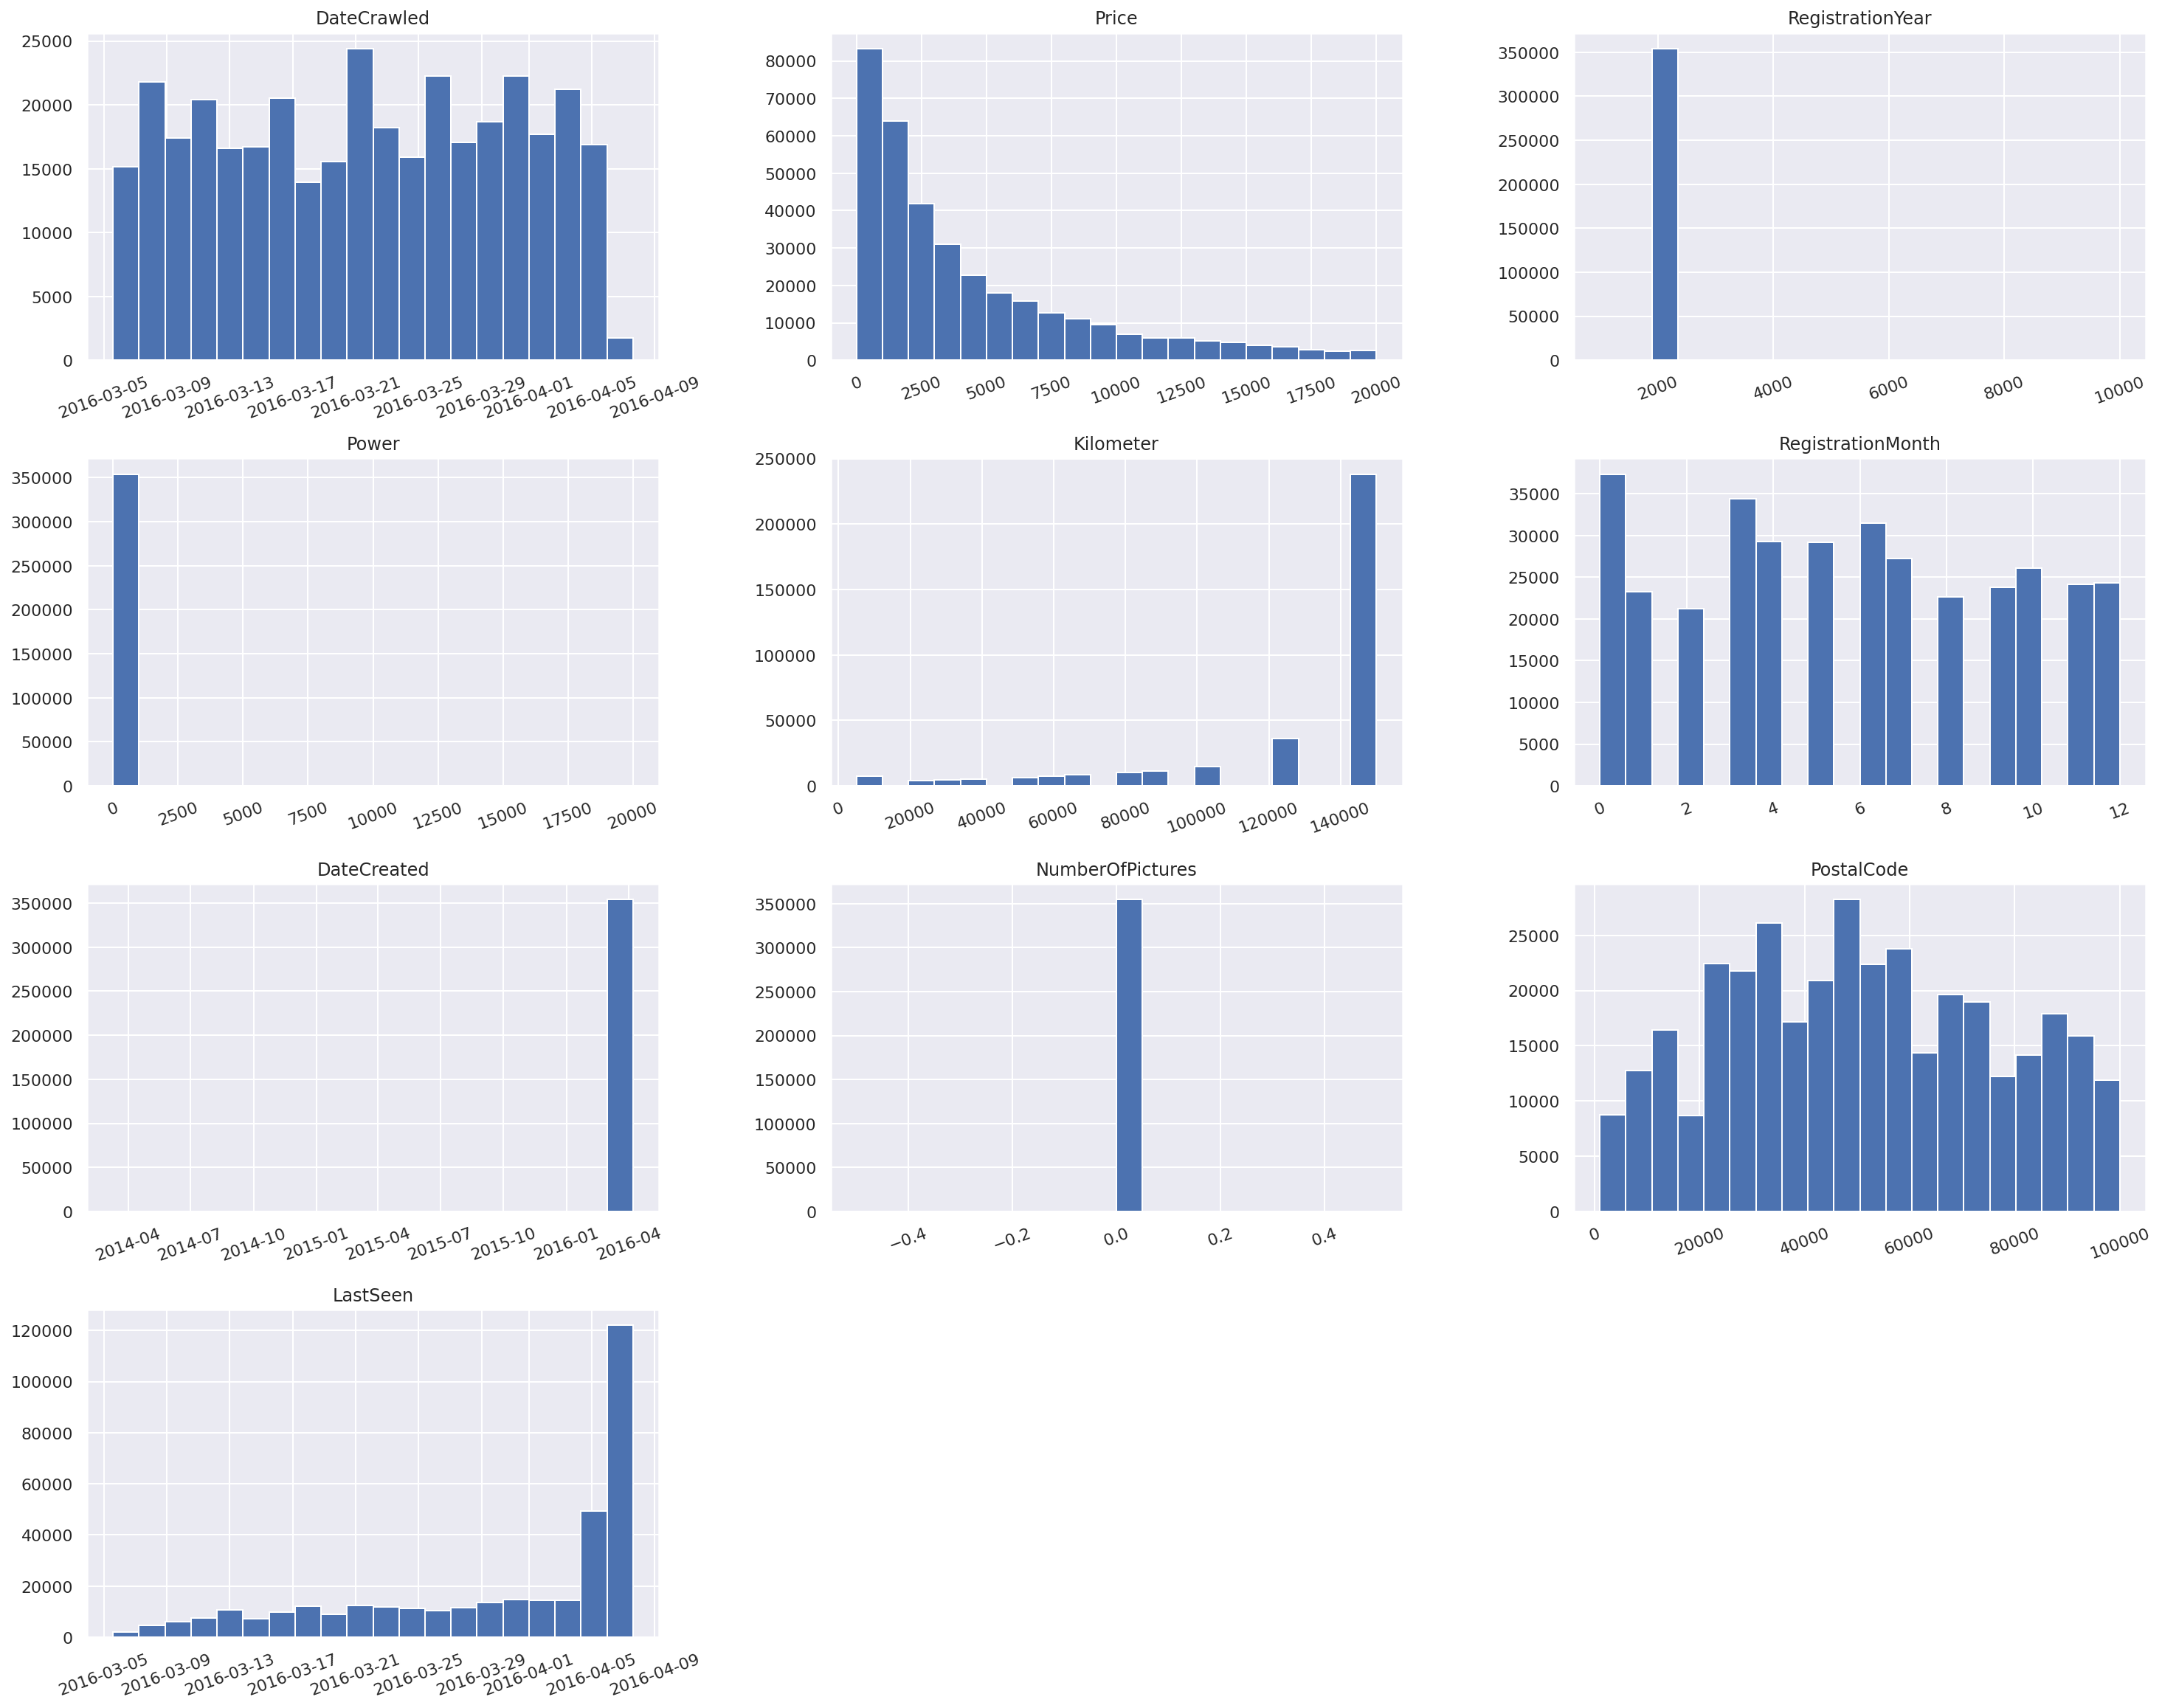

In [8]:
df.hist(bins=20, figsize=(25, 20), xrot=20)
plt.show()

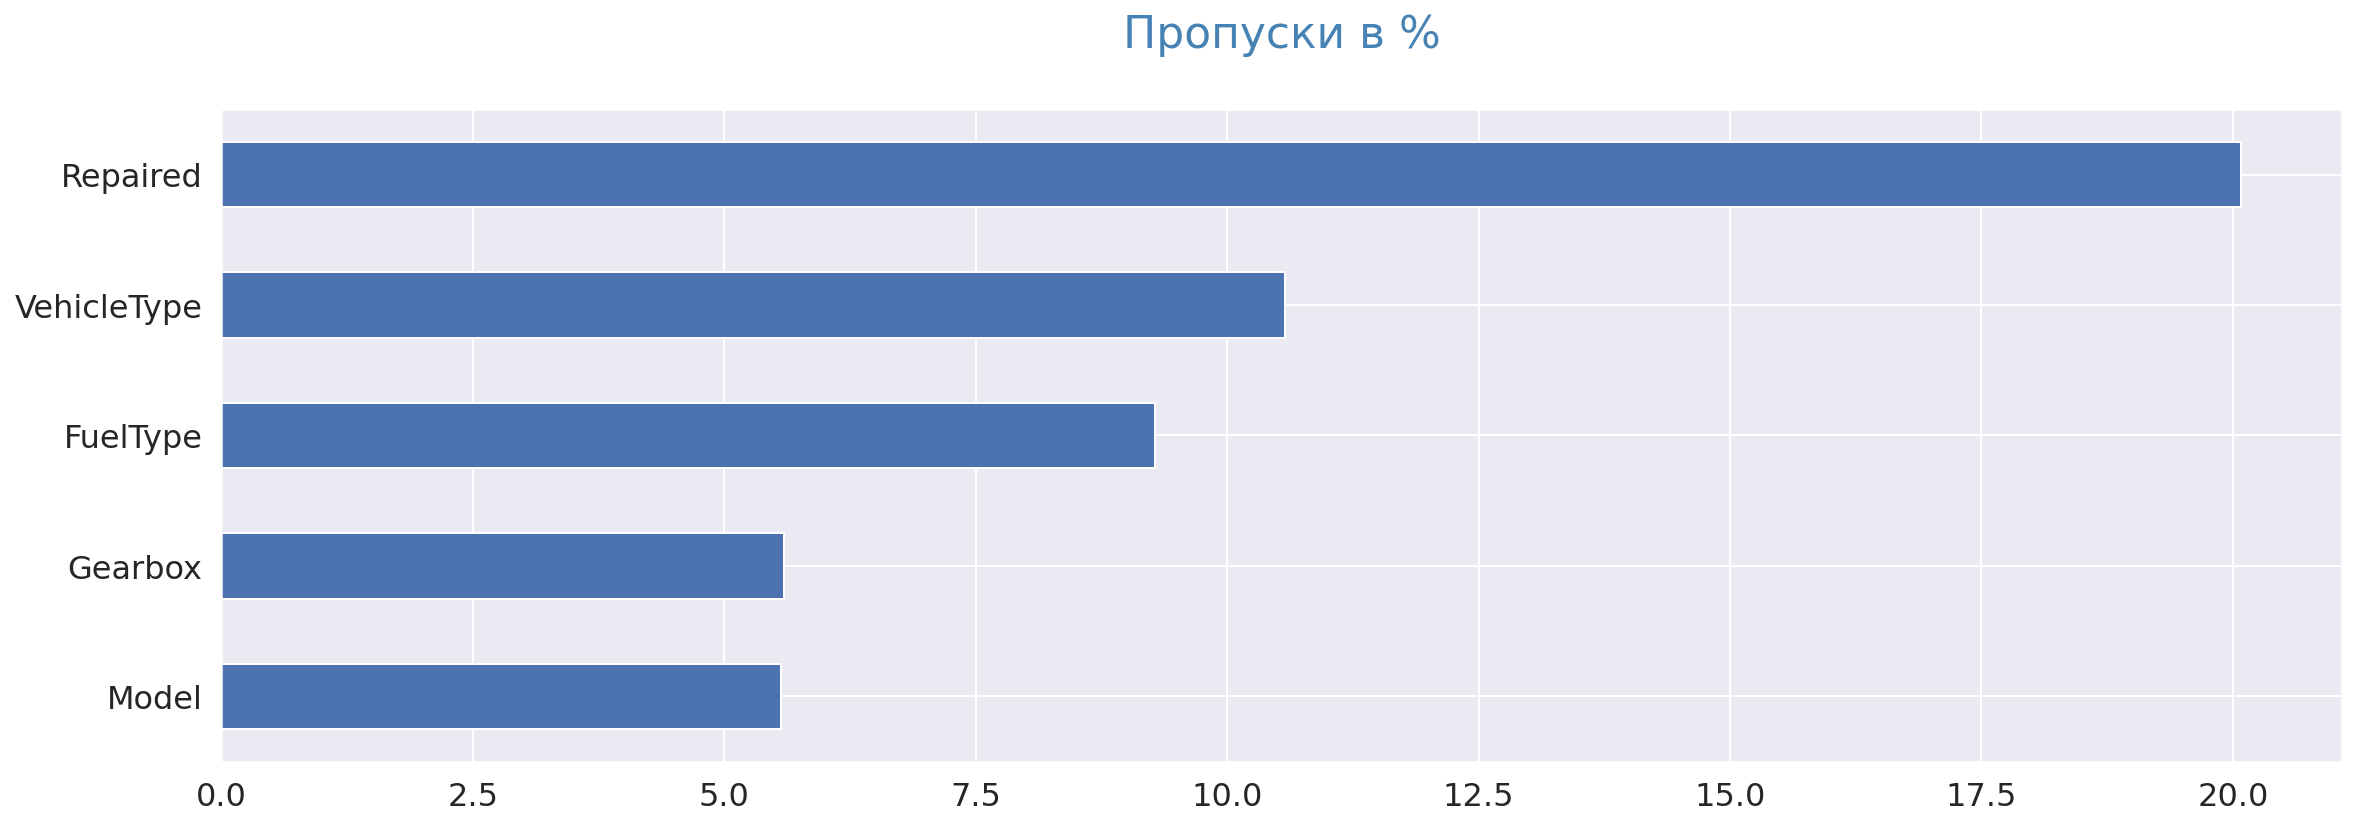

In [9]:
# Визуализируем пропуски
(
    (df.isna().mean()*100)
    .to_frame()
    .rename(columns = {0:'space'})
    .query('space > 0')
    .sort_values(by = 'space', ascending = True)
    .plot(kind= 'barh', figsize=(19,6), legend = False, fontsize = 16)
    .set_title('Пропуски в %' + "\n", fontsize = 22, color = 'SteelBlue')    
)
plt.show()

В данных много аномалий и пропусков. Далее осмотрим каждый признак отдельно.

### `Price` — цена (евро)

In [10]:
df['Price'].sort_values()

205926        0
204097        0
204099        0
204104        0
62604         0
          ...  
214341    20000
66054     20000
197617    20000
143161    20000
113554    20000
Name: Price, Length: 354369, dtype: int64

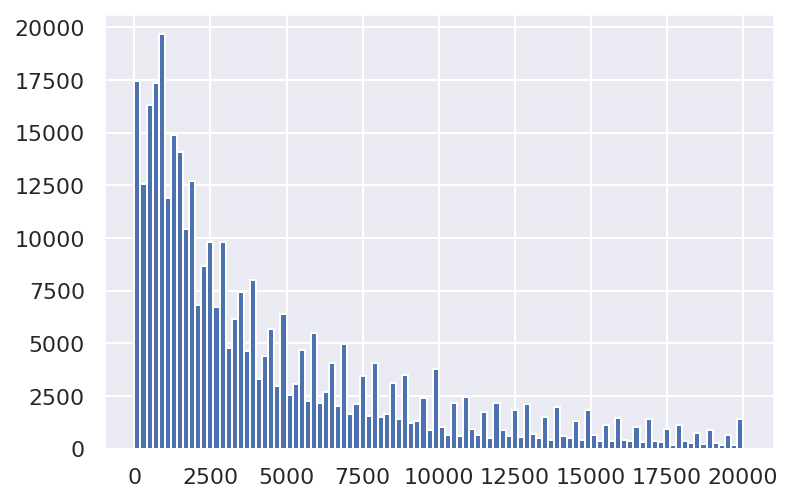

In [11]:
df['Price'].hist(bins=100)
plt.show()

На лицо аномальное распределение на нулевых значениях. Также большинство значений округлены, что естественно для значений цены, заполняемых пользователем.

In [12]:
df['Price'].value_counts()

0        10772
500       5670
1500      5394
1000      4649
1200      4594
         ...  
13180        1
10879        1
2683         1
634          1
8188         1
Name: Price, Length: 3731, dtype: int64

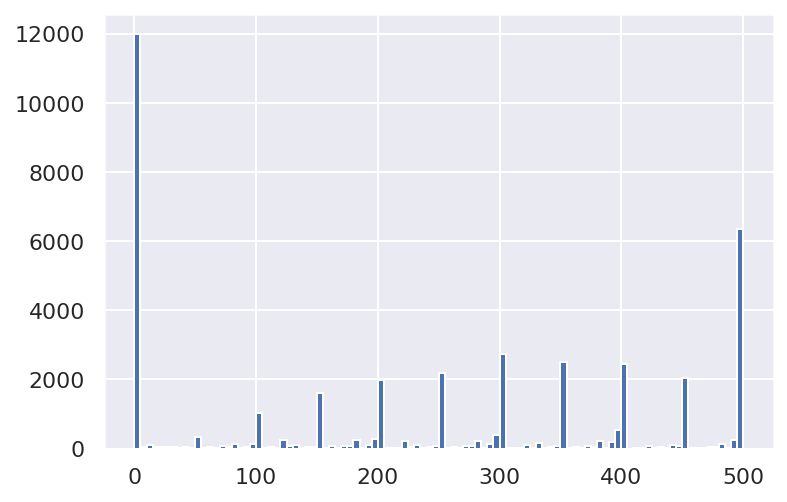

In [13]:
df['Price'].hist(bins=100, range=(0, 500))
plt.show()

Вероятнее всего, нулевые значения означают пропуски значений цены, а так как это целевой признак, необходимо удалить все соответствующие объекты из выборки.

In [14]:
df = df[df['Price'] != 0]

### `VehicleType` — тип автомобильного кузова

In [15]:
df['VehicleType'].value_counts(dropna=False)

sedan          89405
small          78018
wagon          63701
NaN            33750
bus            28345
convertible    19865
coupe          15636
suv            11791
other           3086
Name: VehicleType, dtype: int64

### `DateCrawled` — дата скачивания анкеты из базы

In [16]:
df['DateCrawled'].sort_values()

329497   2016-03-05 14:06:22
220583   2016-03-05 14:06:23
99885    2016-03-05 14:06:24
324763   2016-03-05 14:06:24
176823   2016-03-05 14:06:24
                 ...        
204218   2016-04-07 14:36:53
53739    2016-04-07 14:36:54
301030   2016-04-07 14:36:55
339649   2016-04-07 14:36:56
90713    2016-04-07 14:36:58
Name: DateCrawled, Length: 343597, dtype: datetime64[ns]

### `LastSeen` — дата последней активности пользователя

In [17]:
df['LastSeen'].sort_values()

296785   2016-03-05 14:15:08
262341   2016-03-05 14:15:16
130462   2016-03-05 14:15:39
285695   2016-03-05 14:18:30
169065   2016-03-05 14:25:59
                 ...        
215705   2016-04-07 14:58:50
219959   2016-04-07 14:58:50
68870    2016-04-07 14:58:50
290312   2016-04-07 14:58:50
327303   2016-04-07 14:58:51
Name: LastSeen, Length: 343597, dtype: datetime64[ns]

### `DateCreated` — дата создания анкеты

In [18]:
df['DateCreated'].sort_values()

61207    2014-03-10
4001     2015-03-20
342275   2015-06-18
86601    2015-08-07
175103   2015-08-10
            ...    
103806   2016-04-07
195235   2016-04-07
334354   2016-04-07
191720   2016-04-07
252050   2016-04-07
Name: DateCreated, Length: 343597, dtype: datetime64[ns]

### `RegistrationMonth` — месяц регистрации автомобиля

In [19]:
df['RegistrationMonth'].value_counts()

3     33823
0     32881
6     30847
4     28701
5     28535
7     26678
10    25610
12    23770
11    23759
9     23382
1     22663
8     22134
2     20814
Name: RegistrationMonth, dtype: int64

Очевидно, что нулевое значение свидетельствует о пропуске значения.

In [20]:
df['RegistrationMonth'] = df['RegistrationMonth'].where(~(df['RegistrationMonth'] == 0), np.nan)

### `RegistrationYear` — год регистрации автомобиля

In [21]:
df['RegistrationYear'].sort_values()

183779    1000
60017     1000
213499    1000
110123    1000
286928    1000
          ... 
128677    9999
62395     9999
331753    9999
301279    9999
29426     9999
Name: RegistrationYear, Length: 343597, dtype: int64

In [22]:
df['RegistrationYear'].value_counts()

2000    23072
1999    21995
2005    21524
2006    19679
2001    19654
        ...  
1949        1
2222        1
5300        1
8888        1
2290        1
Name: RegistrationYear, Length: 140, dtype: int64

In [23]:
df['RegistrationYear'][df['RegistrationYear'] < 1999].value_counts().head(20)

1998    17178
1997    13991
1996    10364
1995     8953
1994     4615
1993     3268
1992     2853
1991     2609
1990     2458
1989     1235
1988      903
1985      667
1987      627
1986      502
1980      490
1983      403
1984      382
1982      300
1970      284
1978      276
Name: RegistrationYear, dtype: int64

In [24]:
df['RegistrationYear'][df['RegistrationYear'] > 2016].value_counts()

2017    9895
2018    3782
9999      18
2019      16
5000      16
3000       6
6000       5
7000       4
2500       3
4000       3
9000       2
5555       2
4500       2
5911       2
8000       2
9450       1
5900       1
4100       1
2222       1
3700       1
6500       1
2900       1
5300       1
8500       1
8888       1
8200       1
2200       1
7800       1
2290       1
2066       1
5600       1
4800       1
3800       1
3200       1
2800       1
7100       1
Name: RegistrationYear, dtype: int64

В данных много аномальных значений, судя по всему, вызванных ошибочным сбором пользовательских данных. Все значения больше 2018 года и меньше 1990 будем считать аномалиями и удалим.

In [29]:
df['RegistrationYear'] = df['RegistrationYear'].where(~(df['RegistrationYear'] < 1990) & 
                                                      ~(df['RegistrationYear'] > 2018), np.nan)

Также имеется конфликт с признаками `DateCrawled`, `DateCreated` и `LastSeen`.
<br>
Признаки `DateCrawled` и `LastSeen` содержат даты с 2016.03.05 до 2016.04.07
<br>
А `DateCreated` с 2014.03.10 до 2016.04.07

In [30]:
df[(df['RegistrationYear'] == 2016) & (df['RegistrationMonth'] > 4)].shape[0] + \
df[df['RegistrationYear'] == 2017].shape[0] + df[df['RegistrationYear'] == 2018].shape[0]

18131

В выборке имеется 18131 машин с годом регистрации второй половины 2016 года, а также 2017 и 2018 годов, что вряд ли может быть обычной ошибкой заполнения в силу количества данных. После уточнений у ответственнго лица, было принято решение верить данным в `DateCrawled`, `DateCreated` и `LastSeen` и не верить в `RegistrationYear`.

In [31]:
mask = (
            (df['RegistrationYear'] > df['DateCreated'].dt.year) | 
            (df['RegistrationYear'] > df['DateCrawled'].dt.year) | 
            (df['RegistrationYear'] > df['LastSeen'].dt.year)
        ) | (
                (
                    (df['RegistrationYear'] == df['DateCreated'].dt.year) | 
                    (df['RegistrationYear'] == df['DateCrawled'].dt.year) | 
                    (df['RegistrationYear'] == df['LastSeen'].dt.year)
            ) & (
                    (df['RegistrationMonth'] > df['DateCreated'].dt.month) | 
                    (df['RegistrationMonth'] > df['DateCrawled'].dt.month) | 
                    (df['RegistrationMonth'] > df['LastSeen'].dt.month)
                )
        )
mask.sum()

18645

Удалим все значения `RegistrationYear`, превышающие меньшую из дат `DateCrawled`, `DateCreated` и `LastSeen` (с учетом `RegistrationMonth`). Всего будет потеряно 18645 значений.

In [32]:
df['RegistrationYear'] = df['RegistrationYear'].where(~mask, np.nan)

### `Gearbox` — тип коробки передач

In [33]:
df['Gearbox'].value_counts(dropna=False)

manual    261373
auto       64869
NaN        17355
Name: Gearbox, dtype: int64

### `Power` — мощность (л. с.)

In [34]:
df['Power'].sort_values()

0             0
141979        0
141987        0
142046        0
142047        0
          ...  
63986     17932
132485    19208
114106    19211
299180    19312
219584    20000
Name: Power, Length: 343597, dtype: int64

In [35]:
df['Power'].value_counts()

0        36360
75       23319
60       15465
150      14170
101      12960
         ...  
923          1
10910        1
4400         1
1689         1
6006         1
Name: Power, Length: 701, dtype: int64

In [36]:
df['Power'][df['Power'] > 450].value_counts()

500      36
476      31
507      11
600       9
1800      8
         ..
1239      1
1240      1
16312     1
1002      1
6920      1
Name: Power, Length: 299, dtype: int64

Среди значений данного признака также много аномальных, вероятно, вызванных ошибочным заполнением клиентом. Все нулевые значения больше удалим. Также удалим значения, выше 450, так как значение цены в выборке ограниченно 20.000 евро и автомобили такой ценовой категории, даже крупные, старые и ремонтированные вряд ли могут иметь двигатель выше 450 лошадиных сил.

In [37]:
df['Power'] = df['Power'].where(~(df['Power'] == 0) & ~(df['Power'] >= 450), np.nan)

### `Model` — модель автомобиля

In [38]:
df['Model'].value_counts(dropna=False)

golf                  28246
other                 23707
3er                   19179
NaN                   17521
polo                  12628
                      ...  
i3                        8
rangerover                4
serie_3                   3
range_rover_evoque        2
serie_1                   1
Name: Model, Length: 251, dtype: int64

### `Kilometer` — пробег (км)

In [39]:
df['Kilometer'].sort_values()

129065      5000
152096      5000
183533      5000
242390      5000
191297      5000
           ...  
141652    150000
141654    150000
141655    150000
141631    150000
354368    150000
Name: Kilometer, Length: 343597, dtype: int64

### `FuelType` — тип топлива

In [40]:
df['FuelType'].value_counts(dropna=False)

petrol      210765
gasoline     97168
NaN          29459
lpg           5166
cng            554
hybrid         227
other          170
electric        88
Name: FuelType, dtype: int64

### `Brand` — марка автомобиля

In [41]:
df['Brand'].value_counts()

volkswagen        74413
opel              38530
bmw               35809
mercedes_benz     31359
audi              28574
ford              24457
renault           17389
peugeot           10781
fiat               9332
seat               6718
mazda              5465
skoda              5435
smart              5171
citroen            5029
nissan             4807
toyota             4536
hyundai            3533
mini               3165
volvo              3122
mitsubishi         2927
sonstige_autos     2847
honda              2715
kia                2407
suzuki             2273
alfa_romeo         2234
chevrolet          1704
chrysler           1368
dacia               890
daihatsu            775
subaru              735
porsche             734
jeep                658
land_rover          534
daewoo              533
saab                515
trabant             498
jaguar              493
rover               462
lancia              457
lada                213
Name: Brand, dtype: int64

### `Repaired` — была машина в ремонте или нет


In [42]:
df['Repaired'].value_counts(dropna=False)

no     243682
NaN     65866
yes     34049
Name: Repaired, dtype: int64

### `NumberOfPictures` — количество фотографий автомобиля

In [43]:
df['NumberOfPictures'].value_counts()

0    343597
Name: NumberOfPictures, dtype: int64

Данный признак не содержит никаких данных.

### Корреляции

In [44]:
phik_overview = df[
                    ['Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
                     'Power', 'Model', 'Kilometer', 'RegistrationMonth',
                     'FuelType', 'Brand', 'Repaired']
                    ].phik_matrix()
phik_overview = phik_overview['Price'].sort_values(ascending=False).iloc[1:].reset_index()
cm = sns.color_palette("magma", as_cmap=True)
corr = phik_overview.style.background_gradient(cmap=cm, subset=['Price'])
corr

interval columns not set, guessing: ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']


### Итоговые пропуски

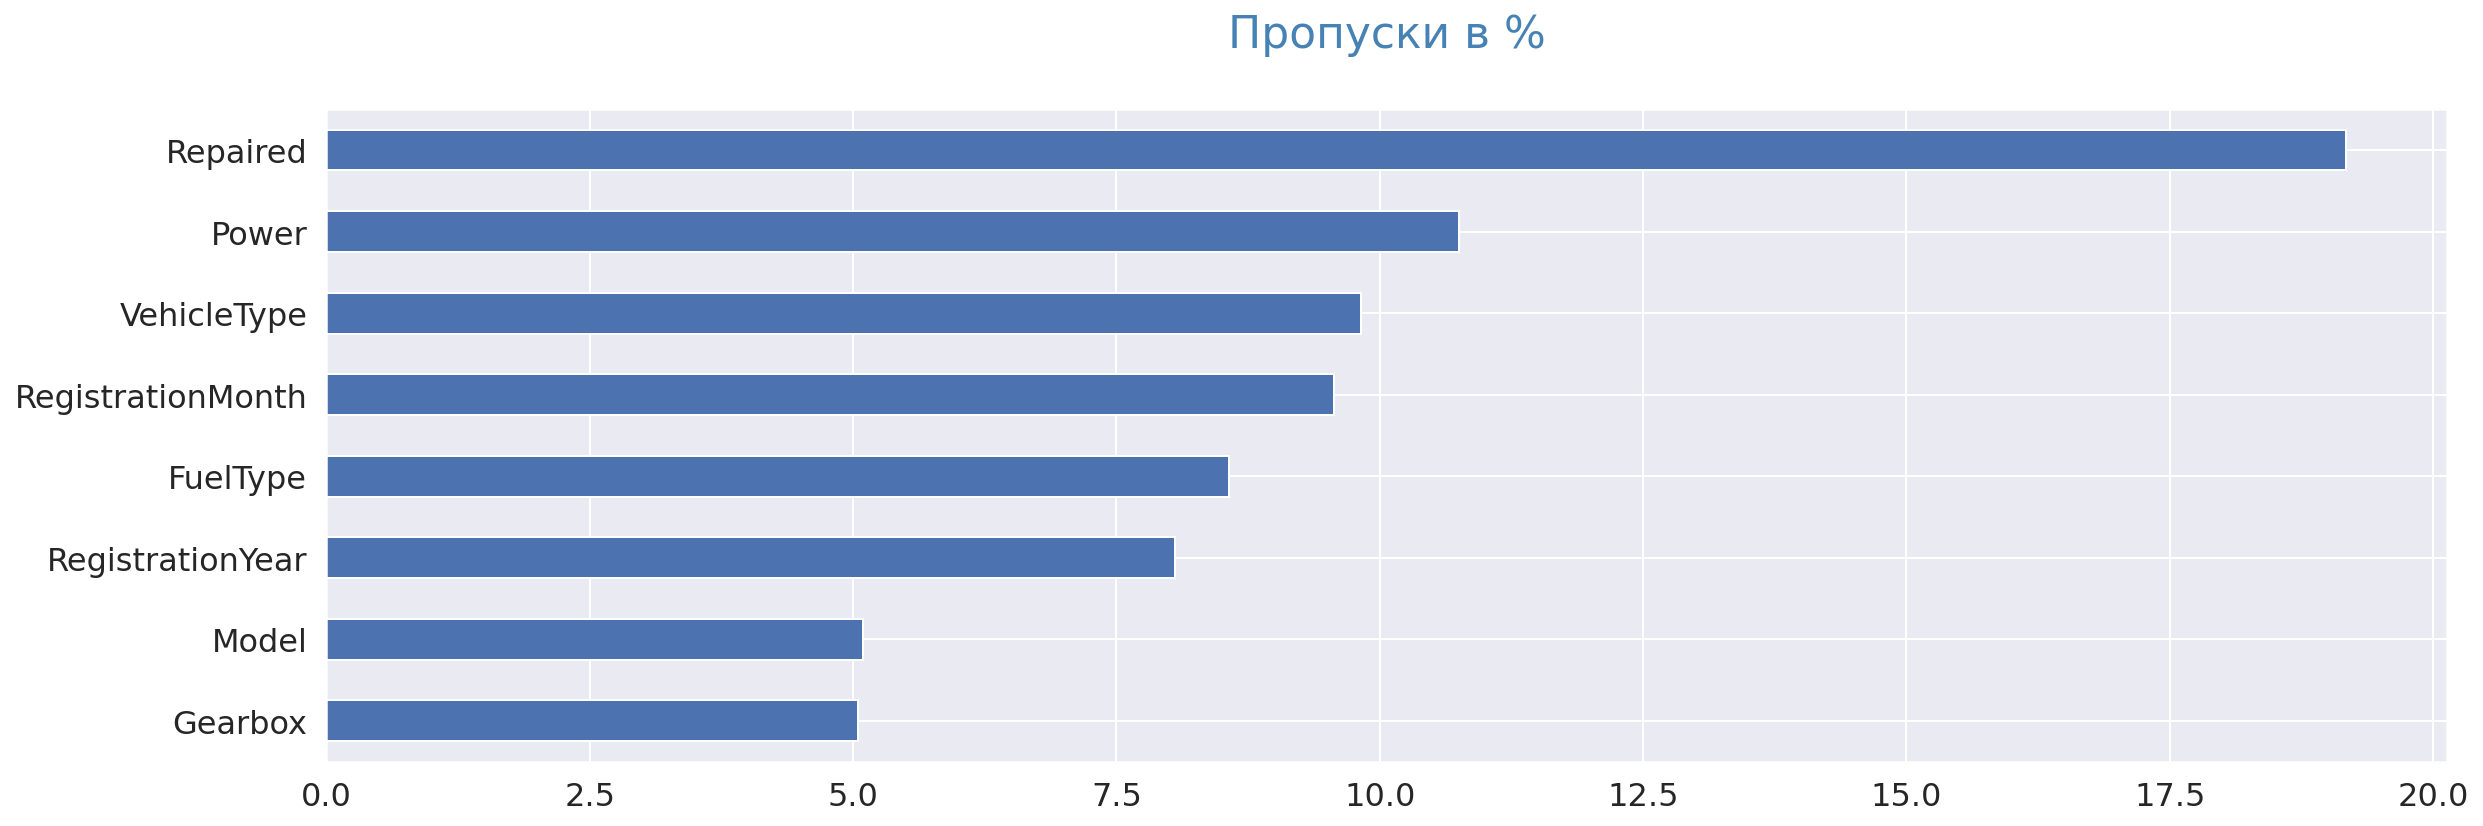

In [45]:
# Визуализируем пропуски
(
    (df.isna().mean()*100)
    .to_frame()
    .rename(columns = {0:'space'})
    .query('space > 0')
    .sort_values(by = 'space', ascending = True)
    .plot(kind= 'barh', figsize=(19,6), legend = False, fontsize = 16)
    .set_title('Пропуски в %' + "\n", fontsize = 22, color = 'SteelBlue')    
)
plt.show()

In [46]:
df_lin = df.dropna()
print(f'Процент потери данных: {(df.shape[0] - df_lin.shape[0]) / df.shape[0] * 100:.0f}%')

Процент потери данных: 35%


35% данных содержит хотя бы один пропуск - соответственно следует отдать предпочтение моделям, которые смогут делать прогноз на неполных данных. Чтобы сократить потерю данных, в категориальных переменных будем кодировать отсутствующие значения числом -1 и удалим признак `RegistrationMonth`, так как он, вероятно, имеет крайне слабое влияние на целевую переменную, но содержит много пропущенных значений.

In [47]:
df = df.drop(columns=['DateCrawled', 'DateCreated', 'LastSeen', 'PostalCode', 'NumberOfPictures'])
df_lin = df.copy()
df_lin = df_lin.drop(columns='RegistrationMonth')
df_lin = df_lin.dropna(subset=['RegistrationYear','Power'])
print(f'Процент потери данных: {(df.shape[0] - df_lin.shape[0]) / df.shape[0] * 100:.0f}%')

Процент потери данных: 17%


In [48]:
df_lin.isna().sum()

Price                   0
VehicleType          7072
RegistrationYear        0
Gearbox              4956
Power                   0
Model                9879
Kilometer               0
FuelType            13448
Brand                   0
Repaired            40002
dtype: int64

### Подготовка данных к обучению

In [48]:
X = ['VehicleType', 'RegistrationYear', 'Gearbox',
     'Power', 'Model', 'Kilometer', 'RegistrationMonth',
     'FuelType', 'Brand', 'Repaired']

X_lin = ['VehicleType', 'RegistrationYear', 'Gearbox',
         'Power', 'Model', 'Kilometer',
         'FuelType', 'Brand', 'Repaired']

y = 'Price'

coll_cat = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
coll_num = ['RegistrationYear', 'Power', 'Kilometer']

In [49]:
train, test = train_test_split(df, test_size=.2, random_state=42)

In [50]:
train_lin, test_lin = train_test_split(df_lin, test_size=.2, random_state=42)

## Обучение моделей

### Baseline

In [51]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)
rmse = make_scorer(rmse)

In [52]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(train[X], train[y])
print(f'RMSE: {rmse(dummy_regr, val[X], val[y]):.2f}')

RMSE: 4499.66


### Linear Regression

Начнем с простых моделей, работающих только на полных данных - если они окажутся точнее, можно будет использовать разные модели для предсказаний на полных и неполных данных.

In [53]:
col_transformer = ColumnTransformer(
                    transformers=[('ordinal', OneHotEncoder(), coll_cat),
                                  ('scaler', StandardScaler(), coll_num)
                                 ],
                    remainder='passthrough',
                    n_jobs=-1
                    )
lreg = Pipeline([('col_transformer', col_transformer), ('lreg', LinearRegression())])
result = cross_validate(lreg, train_lin[X_lin], train_lin[y], scoring=rmse, n_jobs=-1)
score = result['test_score']
score = score[~np.isnan(score)].mean()
fit_time = result['fit_time'].mean()
pred_time = result['score_time'].mean()
print(f'RMSE: {score:.2f}, fit time: {fit_time:.2f} sec, pred time: {pred_time:.2f} sec')

RMSE: 2270.28, fit time: 52.61 sec, pred time: 0.83 sec


### K-NearestNeighborsRegressor

In [54]:
col_transformer = ColumnTransformer(
                    transformers=[('ordinal', OrdinalEncoder(dtype=int,
                                                             handle_unknown='use_encoded_value',
                                                             unknown_value=300,
                                                             encoded_missing_value=-1), coll_cat),
                                  ('scaler', StandardScaler(), coll_num)
                                 ],
                    remainder='passthrough',
                    n_jobs=-1
                    )
lreg = Pipeline([('col_transformer', col_transformer), ('knn', KNeighborsRegressor())])
result = cross_validate(lreg, train_lin[X_lin], train_lin[y], scoring=rmse, n_jobs=-1)
score = result['test_score'].mean()
fit_time = result['fit_time'].mean()
pred_time = result['score_time'].mean()
print(f'RMSE: {score:.2f}, fit time: {fit_time:.2f} sec, pred time: {pred_time:.2f} sec')

RMSE: 1725.73, fit time: 49.66 sec, pred time: 4.19 sec


### Random Forest

In [55]:
%%time
col_transformer = ColumnTransformer(
                    transformers=[('ordinal', OrdinalEncoder(dtype=int,
                                                             handle_unknown='use_encoded_value',
                                                             unknown_value=300,
                                                             encoded_missing_value=-1), coll_cat)],
                    remainder='passthrough',
                    n_jobs=-1
                    )
parameters = {'forest__max_depth': np.linspace(20, 30, 3, dtype=int), 
              'forest__min_samples_leaf': np.linspace(2, 15, 4, dtype=int),
              'forest__max_features': np.linspace(0.2, 0.4, 3)}
forest = Pipeline([('col_transformer', col_transformer), ('forest', RandomForestRegressor(n_estimators=50, random_state=42))])
clf = GridSearchCV(forest, parameters, n_jobs=-1, scoring=rmse, cv=3)
clf.fit(train_lin[X_lin], train_lin[y])

CPU times: total: 11.8 s
Wall time: 14min 53s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('col_transformer',
                                        ColumnTransformer(n_jobs=-1,
                                                          remainder='passthrough',
                                                          transformers=[('ordinal',
                                                                         OrdinalEncoder(dtype=<class 'int'>,
                                                                                        encoded_missing_value=-1,
                                                                                        handle_unknown='use_encoded_value',
                                                                                        unknown_value=300),
                                                                         ['VehicleType',
                                                                          'Gearbox',
                                                                          'Model',
                                                                          'FuelType',
                                                                          'Brand',
                                                                          'Repaired'])])),
                                       ('forest',
                                        RandomForestRegressor(n_estimators=50,
                                                              random_state=42))]),
             n_jobs=-1,
             param_grid={'forest__max_depth': array([20, 25, 30]),
                         'forest__max_features': array([0.2, 0.3, 0.4]),
                         'forest__min_samples_leaf': array([ 2,  6, 10, 15])},
             scoring=make_scorer(rmse))

In [56]:
pd.DataFrame(clf.cv_results_)[
    ['mean_test_score', 'mean_fit_time', 'mean_score_time', 'param_forest__max_depth', 
     'param_forest__max_features', 'param_forest__min_samples_leaf']
].sort_values('mean_test_score').head(10)

mean_test_score  mean_fit_time  mean_score_time param_forest__max_depth  \
20      1487.554079     159.442498        12.194828                      25   
32      1488.550451     154.533183         9.511365                      30   
8       1489.105174     117.190304        15.972316                      20   
28      1499.452601     120.079904        13.493409                      30   
16      1500.030620     140.496890        16.453860                      25   
4       1506.883856     135.610203        15.663003                      20   
9       1541.225586     168.403137        13.706649                      20   
21      1541.692579     161.276136        11.081774                      25   
33      1542.769453     120.043846         6.561067                      30   
24      1545.582317     123.118906        17.458978                      30   

   param_forest__max_features param_forest__min_samples_leaf  
20                        0.4                              2  
32                        0.4                              2  
8                         0.4                              2  
28                        0.3                              2  
16                        0.3                              2  
4                         0.3                              2  
9                         0.4                              6  
21                        0.4                              6  
33                        0.4                              6  
24                        0.2                              2

In [58]:
%%time
parameters = {'forest__n_estimators': [100, 200, 500]}
forest = Pipeline([('col_transformer', col_transformer), ('forest', RandomForestRegressor(max_depth=25,
                                                                                          min_samples_leaf=2,
                                                                                          max_features=0.4,
                                                                                          random_state=42))])
clf = GridSearchCV(forest, parameters, n_jobs=-1, scoring=rmse, cv=3)
clf.fit(train_lin[X_lin], train_lin[y])
pd.DataFrame(clf.cv_results_)[['mean_test_score', 'mean_fit_time', 
                               'mean_score_time', 'param_forest__n_estimators']].sort_values('mean_test_score')

CPU times: total: 18.2 s
Wall time: 3min 44s


mean_test_score  mean_fit_time  mean_score_time param_forest__n_estimators
2      1478.234572     140.755021        11.250692                        500
1      1479.987646      99.596595         7.926321                        200
0      1483.773540      79.682996         7.318206                        100

### LightGBM

In [59]:
indexes_of_categories = [0, 1, 2, 3, 4, 5]

fit_params = {'lgbm__categorical_feature': indexes_of_categories}

col_transformer = ColumnTransformer(
                    transformers=[('ordinal', OrdinalEncoder(dtype=int,
                                                             handle_unknown='use_encoded_value',
                                                             unknown_value=300,
                                                             encoded_missing_value=-1), coll_cat)],
                    remainder='passthrough',
                    n_jobs=-1
                    )
lgbm = Pipeline([('col_transformer', col_transformer), ('lgbm', lgb.LGBMRegressor(max_depth=30,
                                                                                  num_leaves=1000,
                                                                                  n_estimators=92,
                                                                                  random_state=42, 
                                                                                  n_jobs=-1))])
result = cross_validate(lgbm, train_lin[X_lin], train_lin[y], scoring=rmse, n_jobs=-1, fit_params=fit_params)
score = result['test_score'].mean()
fit_time = result['fit_time'].mean()
pred_time = result['score_time'].mean()
print(f'RMSE: {score:.2f}, fit time: {fit_time:.2f} sec, pred time: {pred_time:.2f} sec')

RMSE: 1428.61, fit time: 58.82 sec, pred time: 2.34 sec


Наилучшее качество на данных без пропусков числовых значений показывает градиентный бустинг с настроенными гиперпараметрами.

In [60]:
lgbm = Pipeline([('col_transformer', col_transformer), ('lgbm', lgb.LGBMRegressor(max_depth=30,
                                                                                  num_leaves=1000,
                                                                                  n_estimators=92,
                                                                                  random_state=42, 
                                                                                  n_jobs=-1))])
result = cross_validate(lgbm, train[X], train[y], scoring=rmse, n_jobs=-1, fit_params=fit_params)
score = result['test_score'].mean()
fit_time = result['fit_time'].mean()
pred_time = result['score_time'].mean()
print(f'RMSE: {score:.2f}, fit time: {fit_time:.2f} sec, pred time: {pred_time:.2f} sec')

RMSE: 1592.41, fit time: 228.37 sec, pred time: 4.68 sec


### Final model

Проведем финальное тестирование на отложенной тестовой выборке, обучив модель на объединенной тренировочной и валидационной выборке.

In [62]:
indexes_of_categories = [0, 1, 2, 3, 4, 5]

col_transformer = ColumnTransformer(
                    transformers=[('ordinal', OrdinalEncoder(dtype=int,
                                                             handle_unknown='use_encoded_value',
                                                             unknown_value=300,
                                                             encoded_missing_value=-1), coll_cat)],
                    remainder='passthrough',
                    n_jobs=-1
                    )

lgbm = lgb.LGBMRegressor(max_depth=30,
                          num_leaves=1000,
                          n_estimators=92,
                          random_state=42, 
                          n_jobs=-1)

start_time = time.time()
train = col_transformer.fit_transform(train[X])
y_train = train[y]
test_enc = col_transformer.transform(test[X])
y_test = test[y]
preproc_time = time.time() - start_time

start_time = time.time()
lgbm.fit(train, y_train, categorical_feature=indexes_of_categories)
fit_time = time.time() - start_time

start_time = time.time()
score = rmse(lgbm, test_enc, y_test)
pred_time = time.time() - start_time

print(f'RMSE: {score:.2f}, preproc time: {preproc_time:.2f} sec, fit time: {fit_time:.2f} sec, pred time: {pred_time:.2f} sec')

RMSE: 1564.55, preproc time: 238.72 sec, fit time: 8.17 sec, pred time: 0.26 sec


Большую часть времени занимает предобработка данных - кодирование категориальных переменных.

## Анализ модели

Для начала проанализируем важность признаков по мнению модели.

In [64]:
booster = lgbm.booster_

In [65]:
explainer = shap.TreeExplainer(booster)

In [66]:
shap_values = explainer.shap_values(test_enc)

In [77]:
features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired', 
            'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']
test_data = pd.DataFrame(test_enc, columns=features)

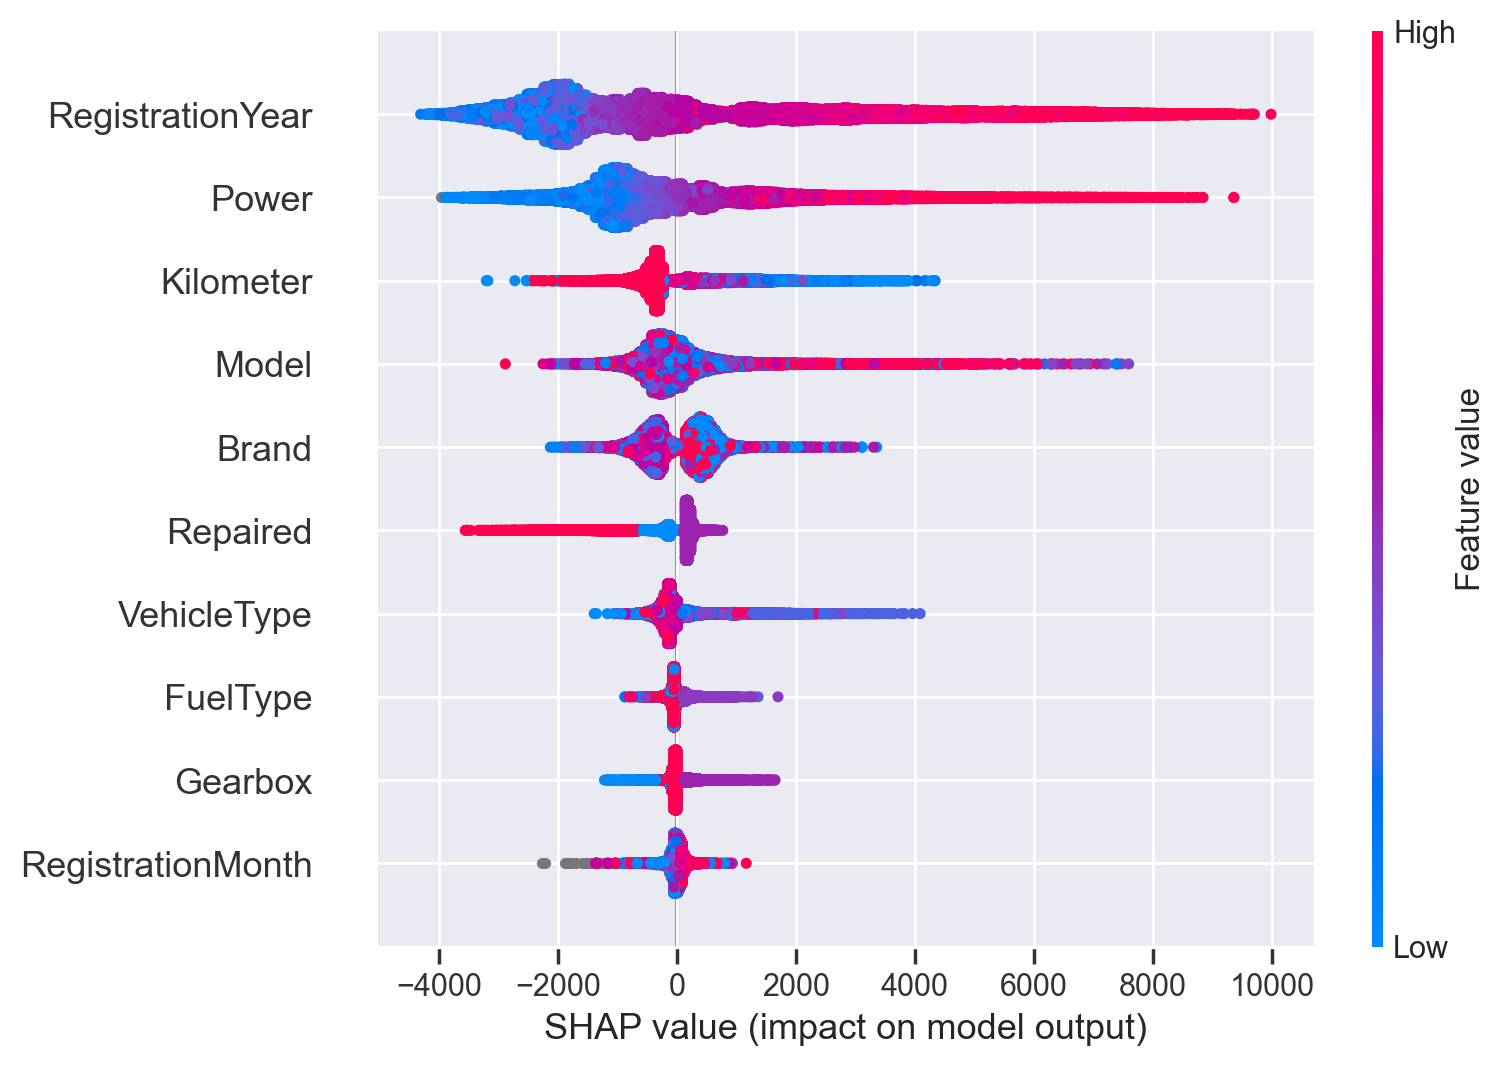

In [76]:
shap.summary_plot(shap_values, test_data)

Также интересно будет взглянуть насколько соответствуют результаты модели и изначально посчитаная 𝜙k-корреляция.

In [81]:
corr

Ранжирование признаков по важности несколько отличается, но год регистрации автомобиля, мощность двигателя, модель и история поломок/дтп влияют более всего. Основное отличие - 𝜙k-корреляция не выявила высокую значимость километража, которую ожидаемо выявила модель.

В заключение осмотрим влияние конкретных значений признаков на предсказание модели.

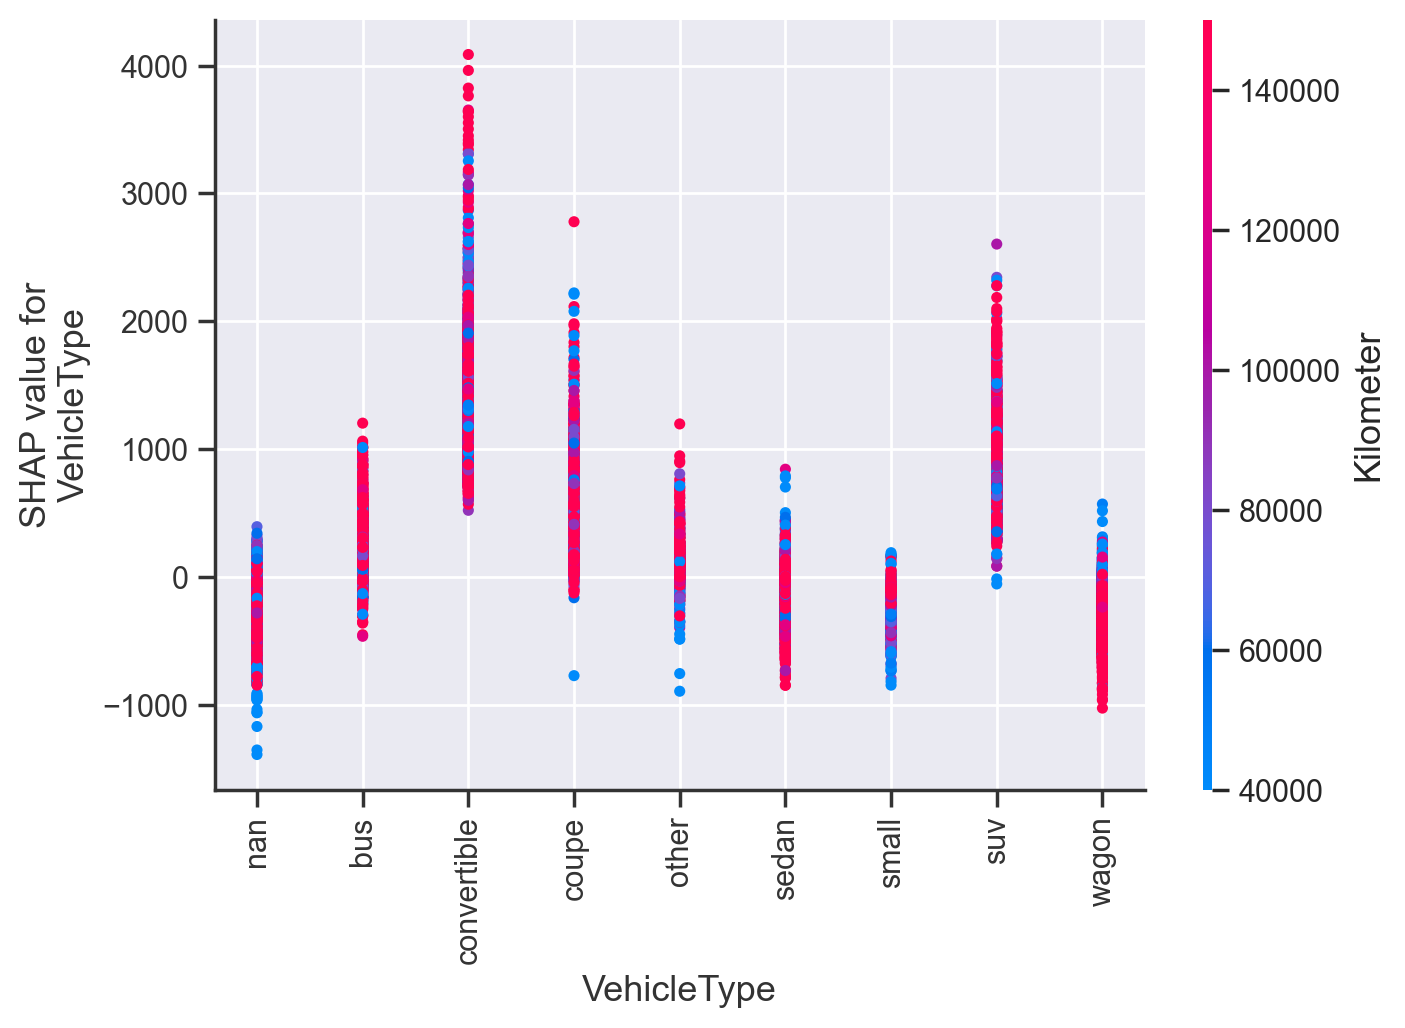

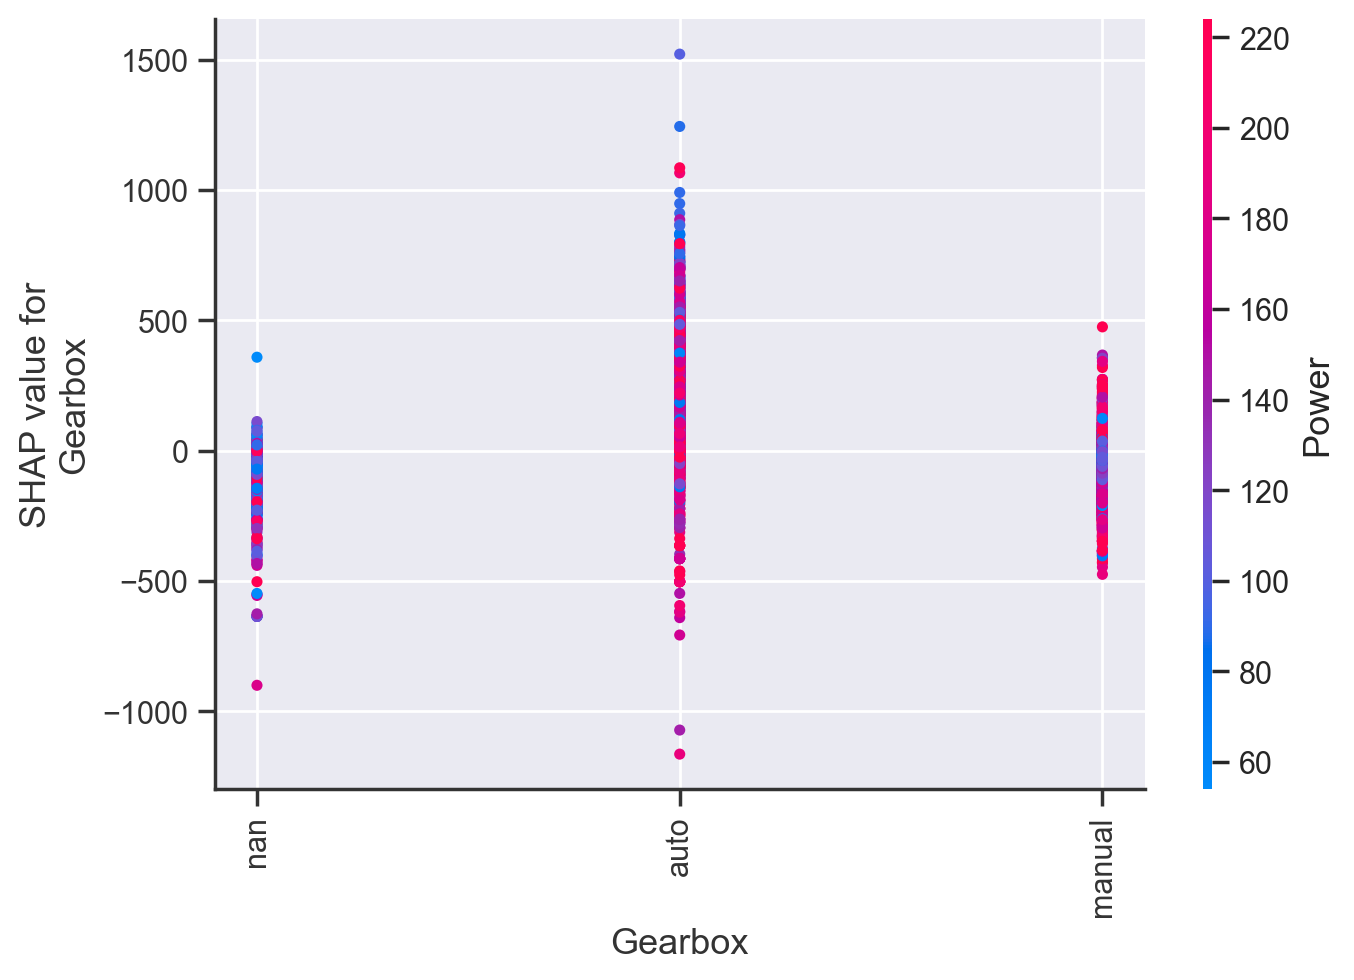

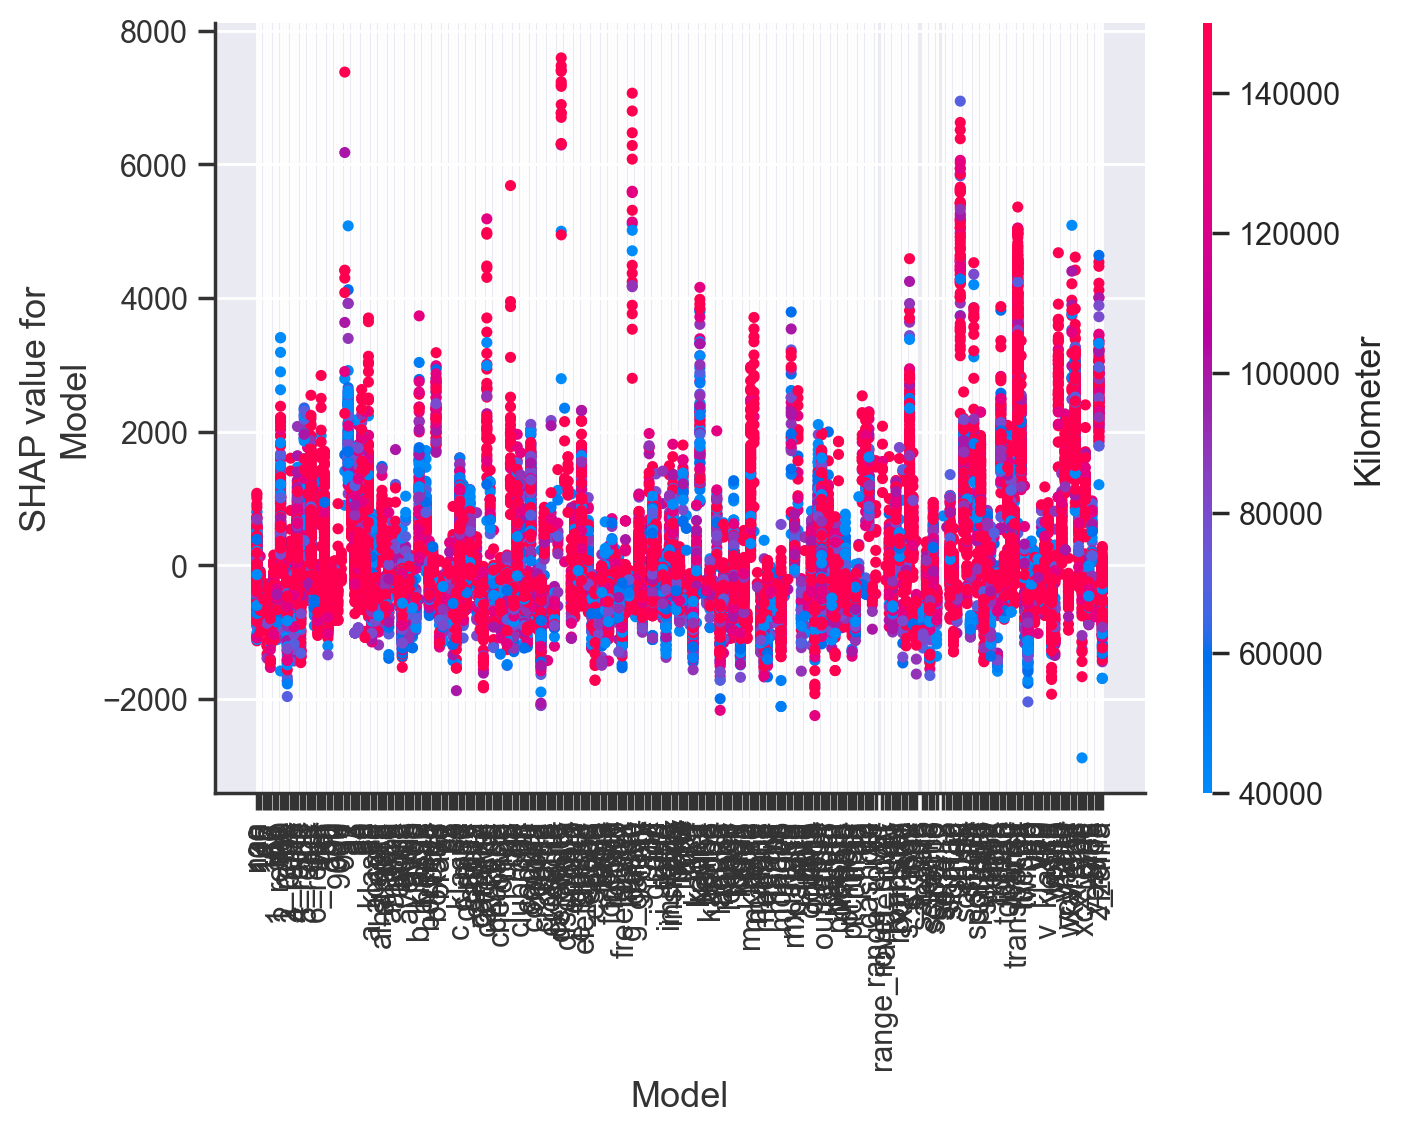

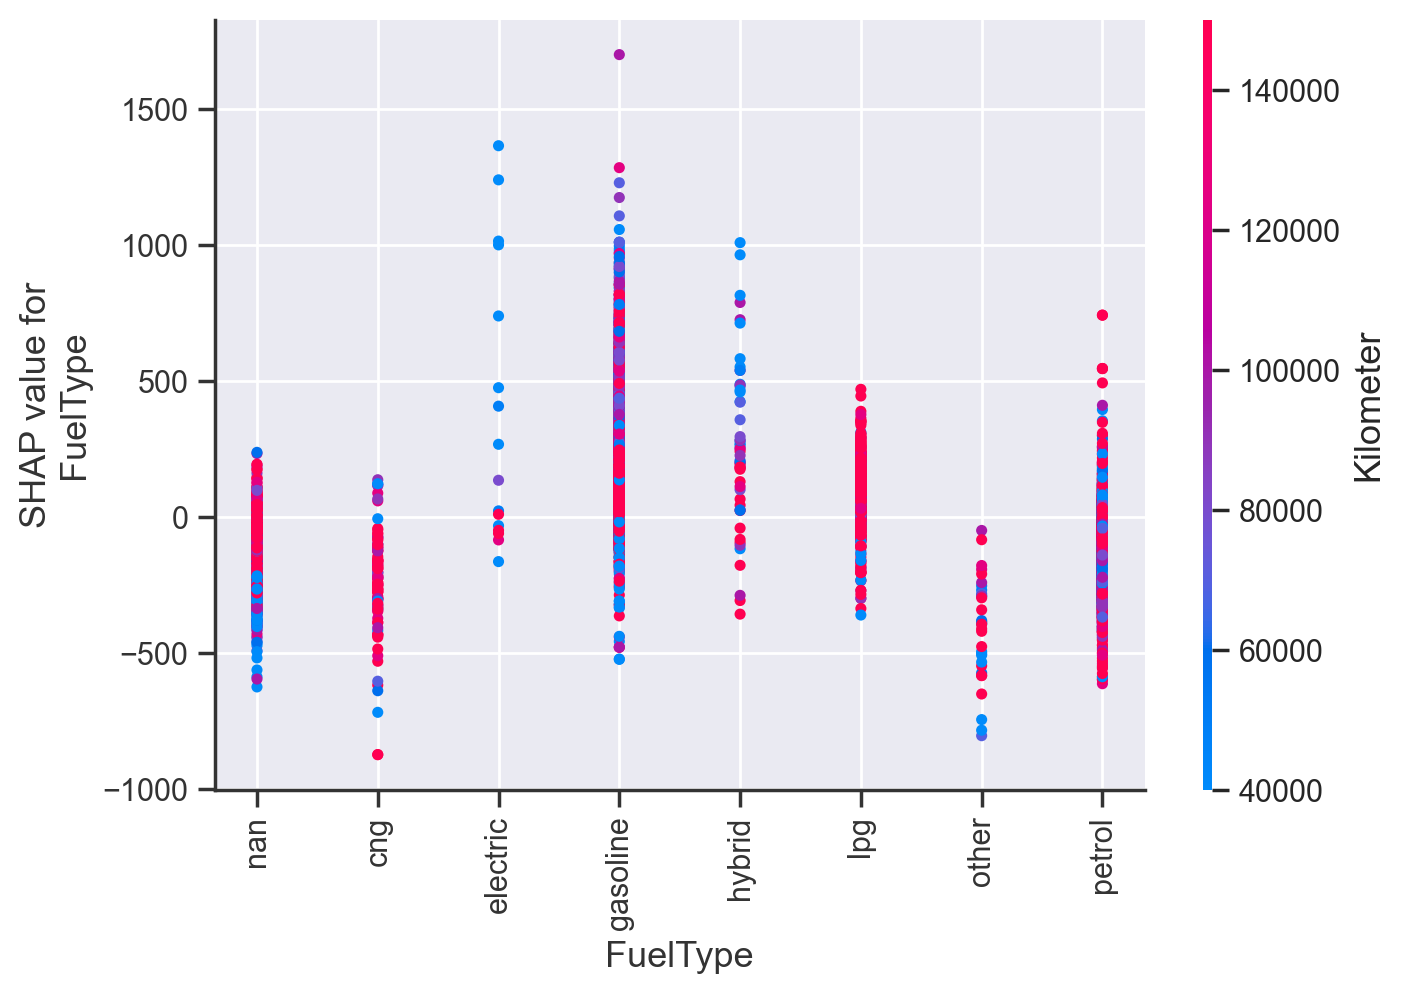

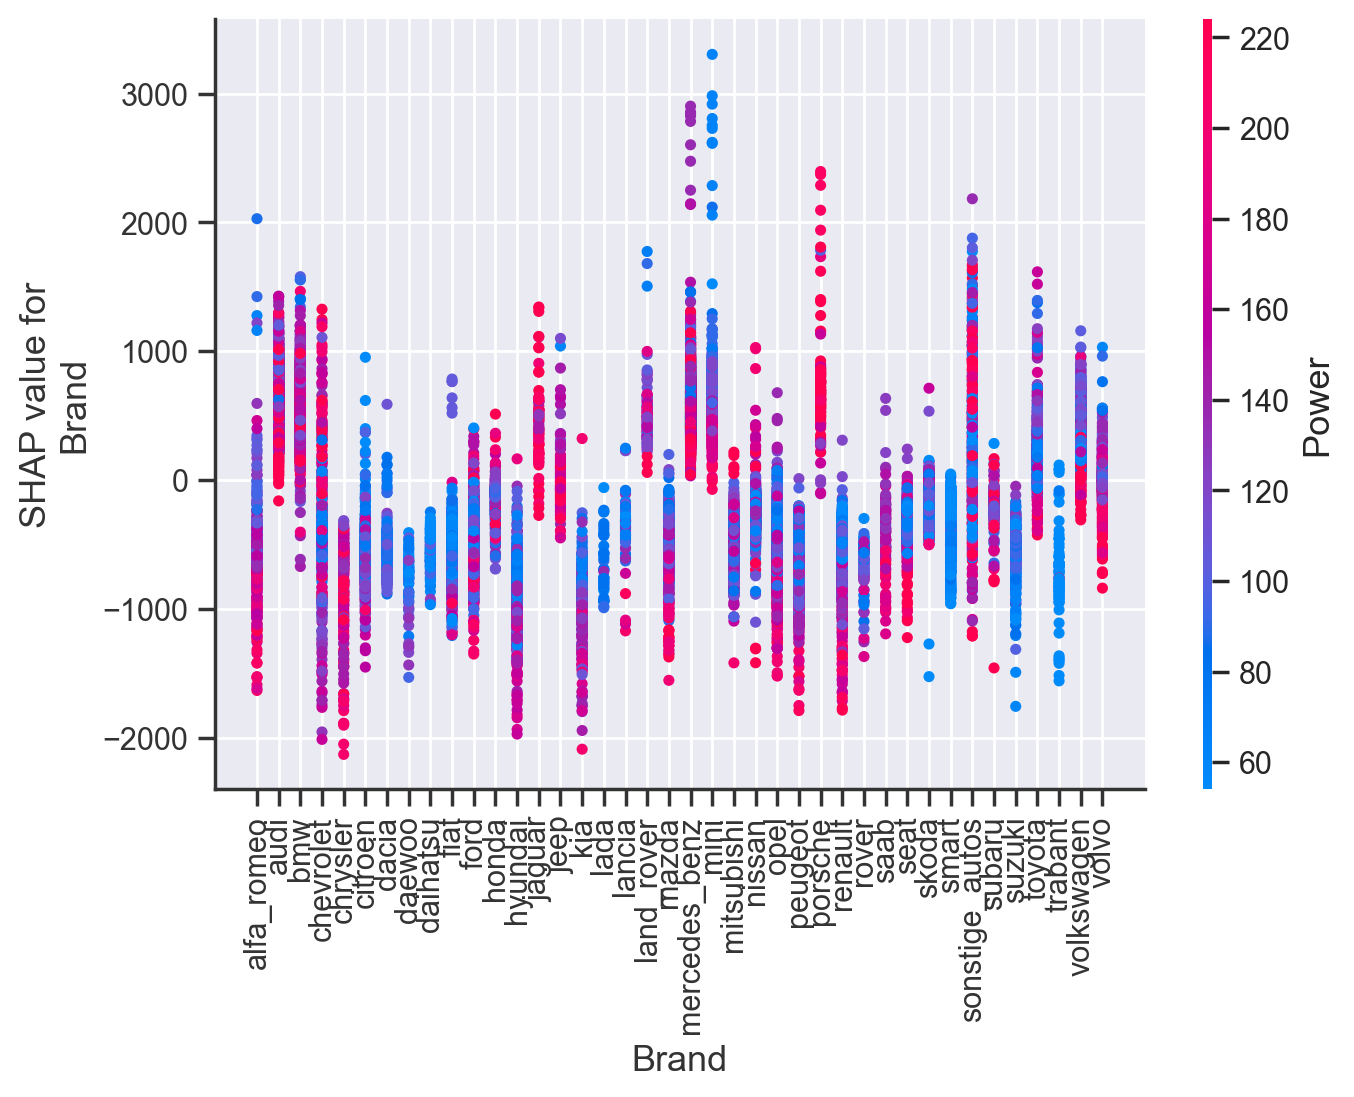

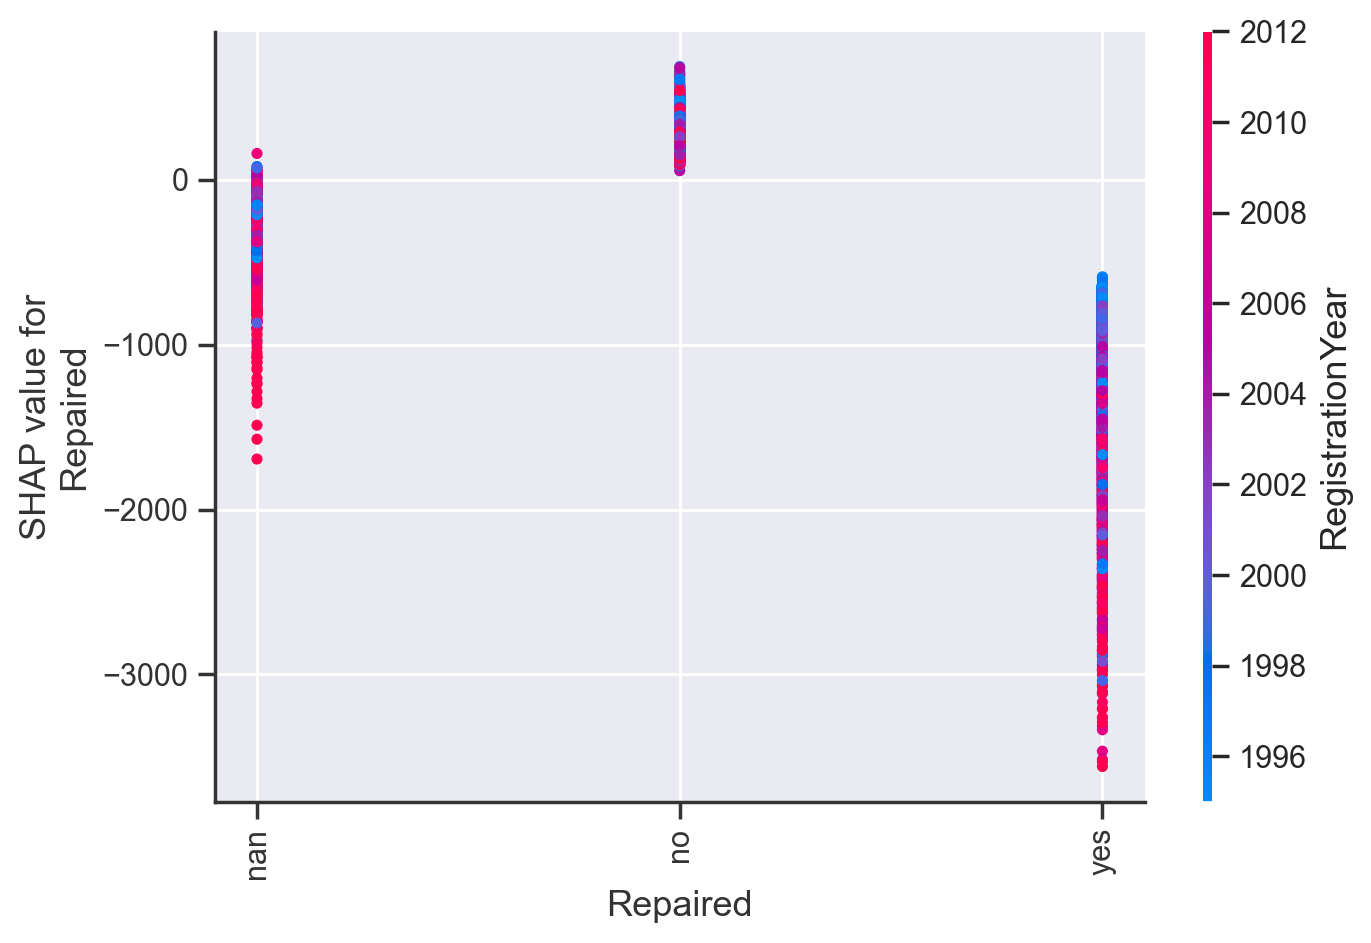

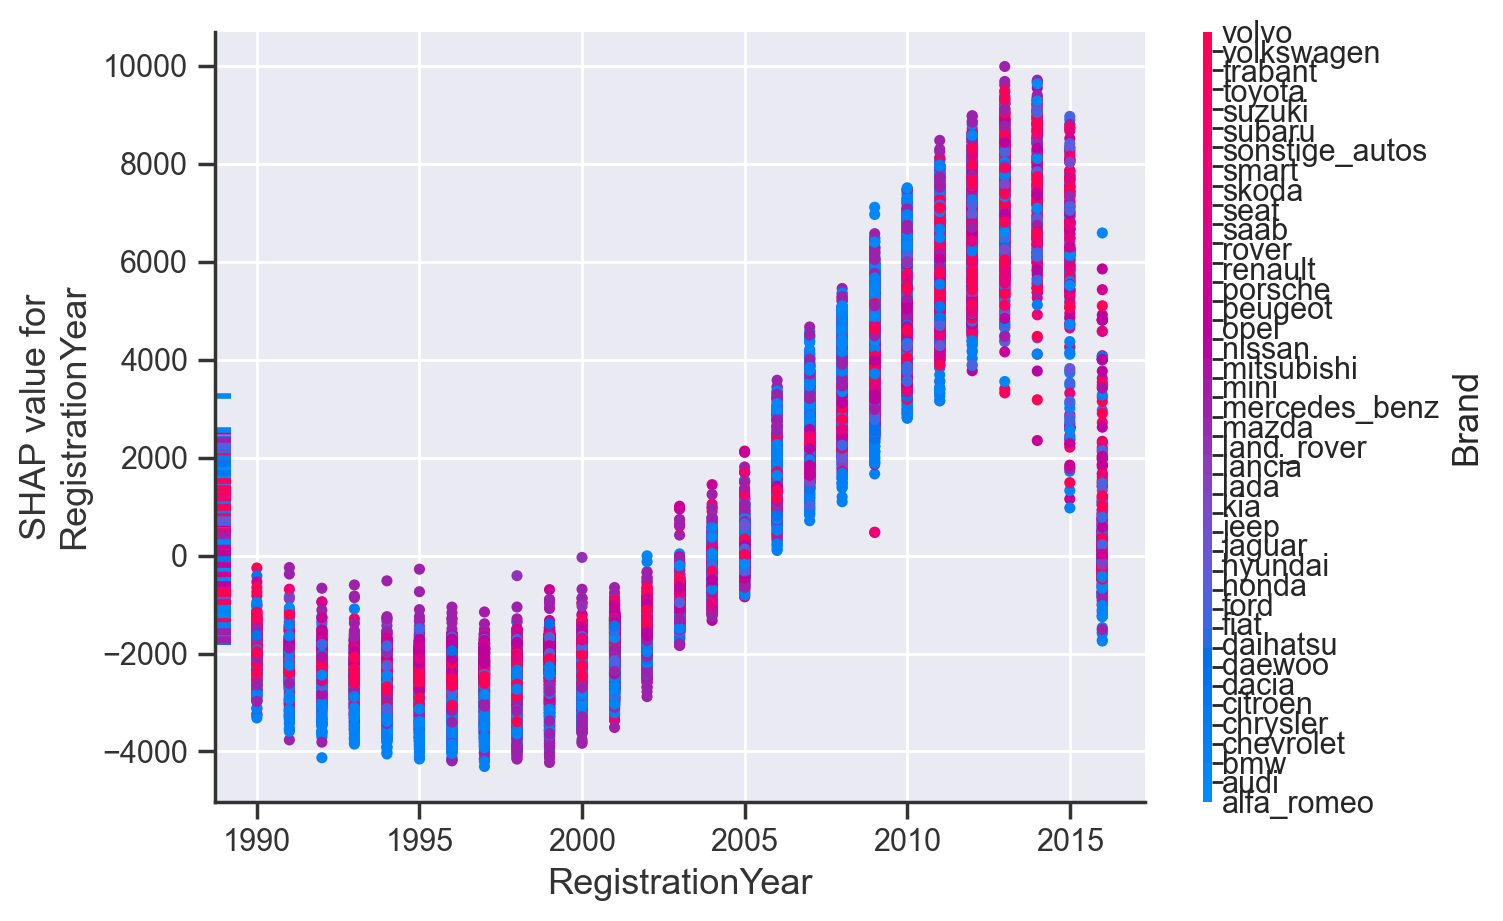

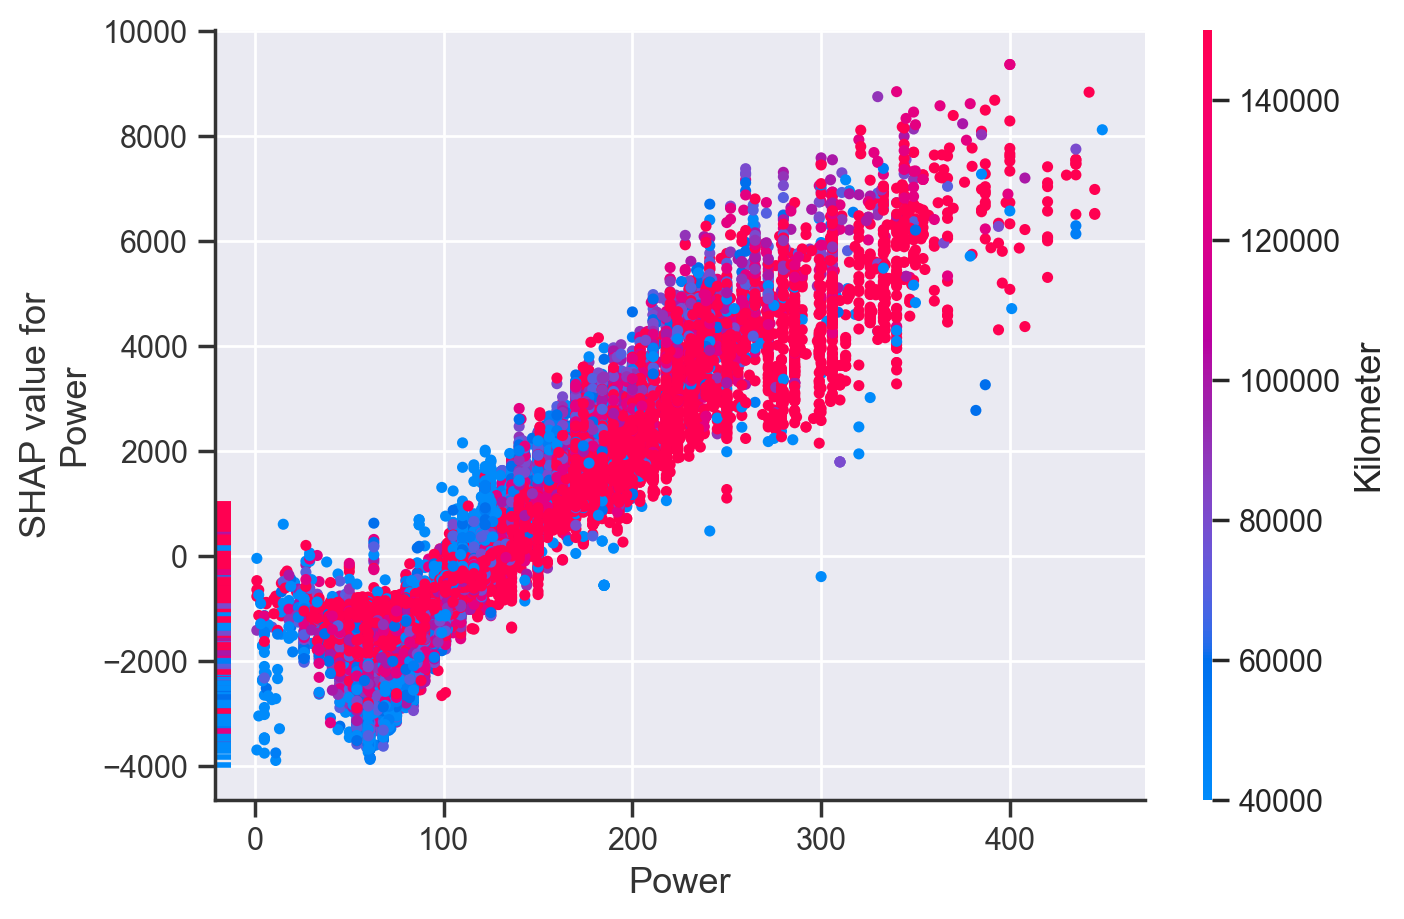

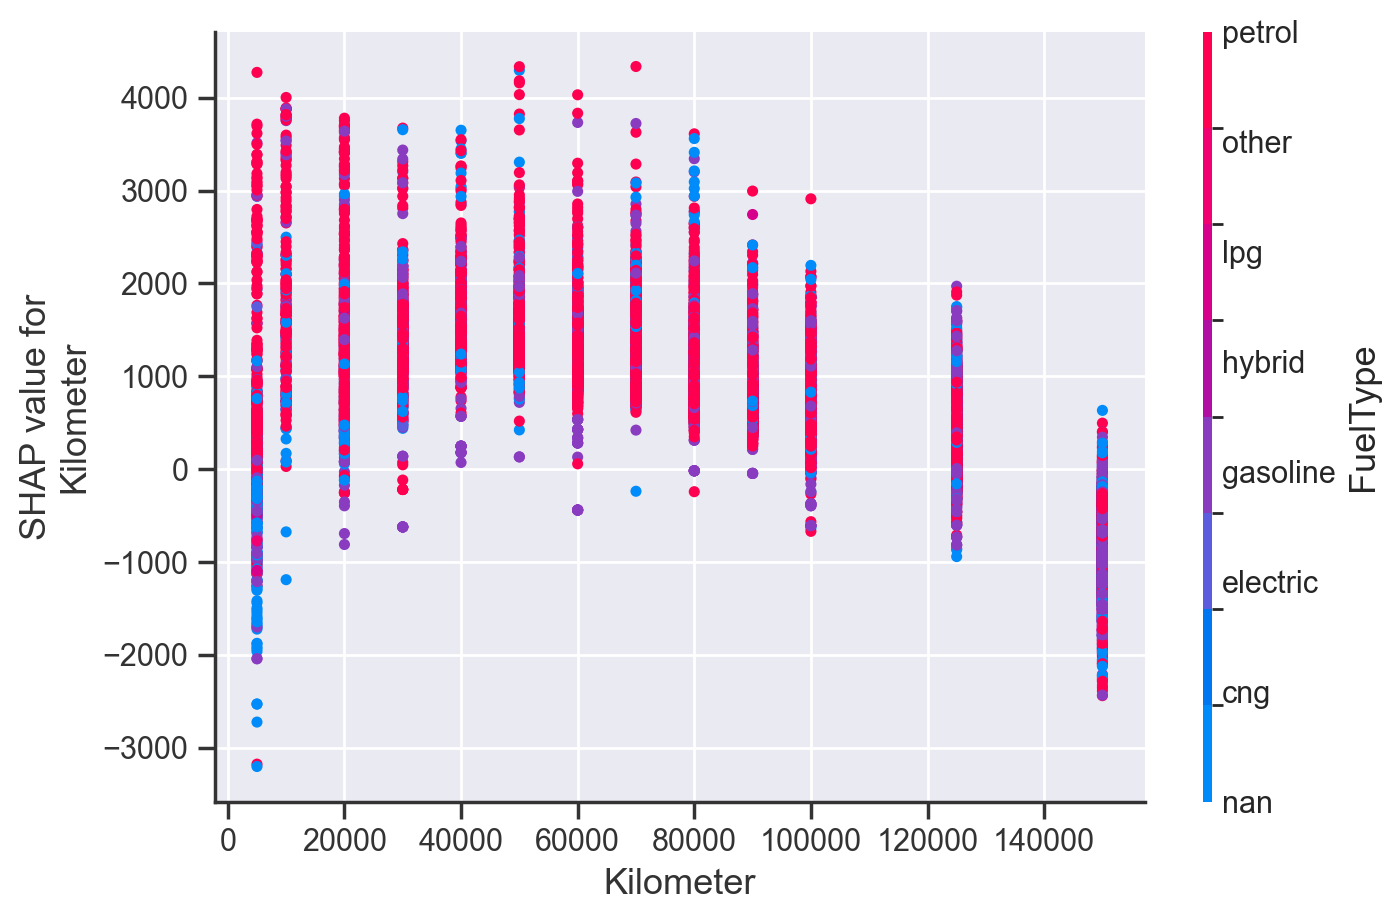

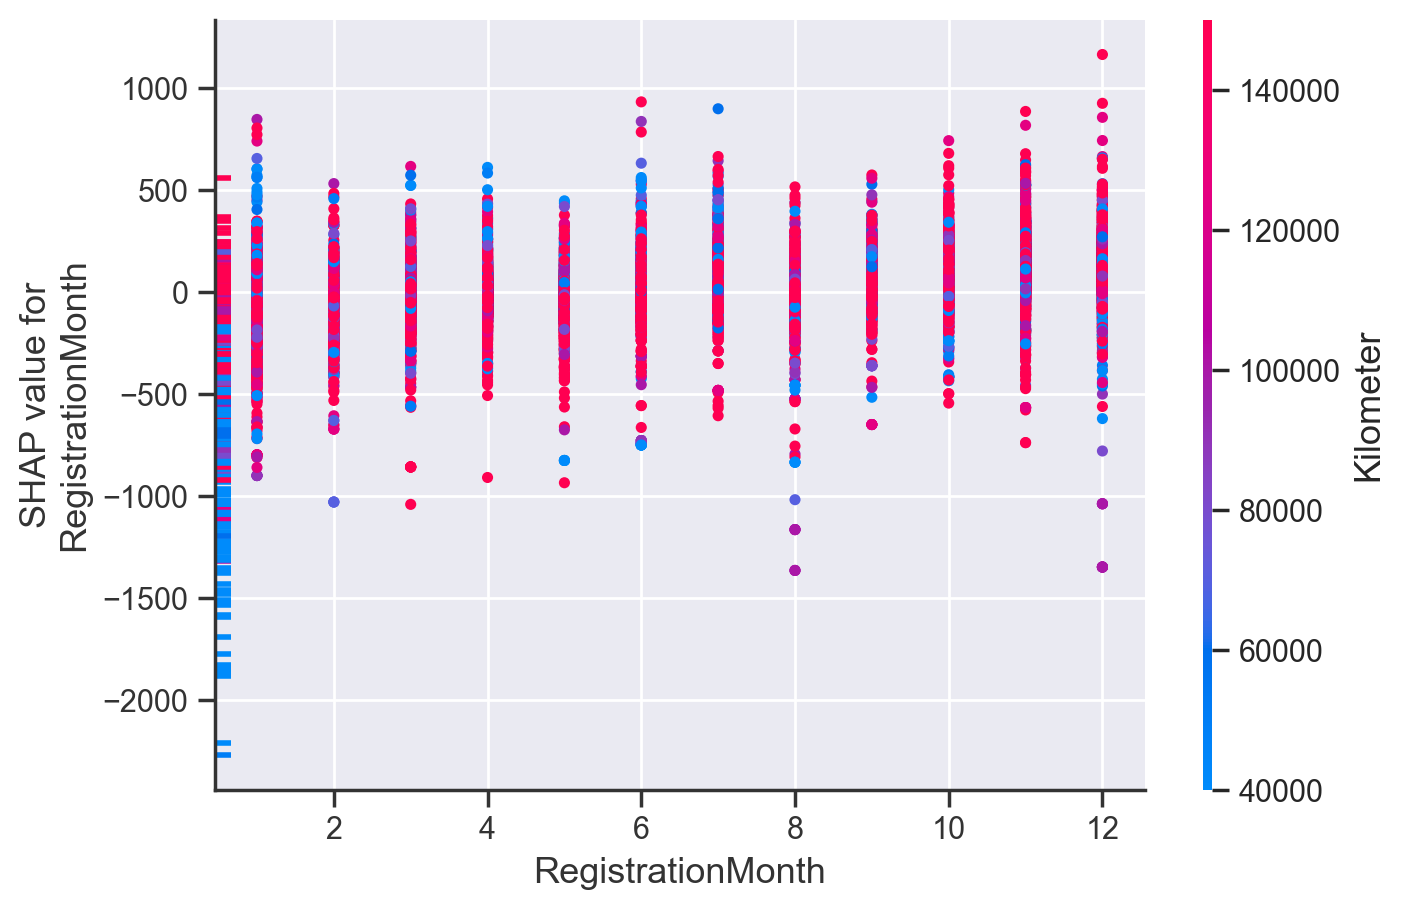

In [100]:
for feature in features:
    shap.dependence_plot(feature, shap_values, test_data, display_features=test.reset_index(drop=True)[features])

- Тип автомобильного кузова: кабриолеты - наиболее дорогие модели, малолитражные и минивены - самые дешевые
- Год регистрации автомобиля: ожидаемо, чем новее автомобиль, тем он дороже, однако после 2015 года средняя цена начала падать. Возможно, это связано с особенностями выборки.
- Тип коробки передач: автомобили с автоматической коробкой стаят в среднем дороже, чем с ручной.
- Мощность (л. с.): с ростом мощности двигателя автомобили стабильно стоят дороже
- Пробег (км): очевидно, с ростом пробега снижается цена автомобиля.
- Месяц регистрации автомобиля: месяц регистрации автомобиля практически не влияет на цену автомобиля.
- Тип топлива: автомобили на сжатом природном газе в среднем стоят меньше всего, однако в целом цена слабо зависит от типа топлива, зато сильно зависит диспресия цены.
- Марка автомобиля: модель выявила четкие ожидаемые зависимости - такие бренды как mercedes или audi стоят значительно больше, чем suzuki или renault
- Была машина в ремонте или нет: машины, бывавшие в ремонте стоят дешевле
- Модель автомобиля: цена очень сильно зависит от модели, для подробного осмотра выводится полный график зависимостей:

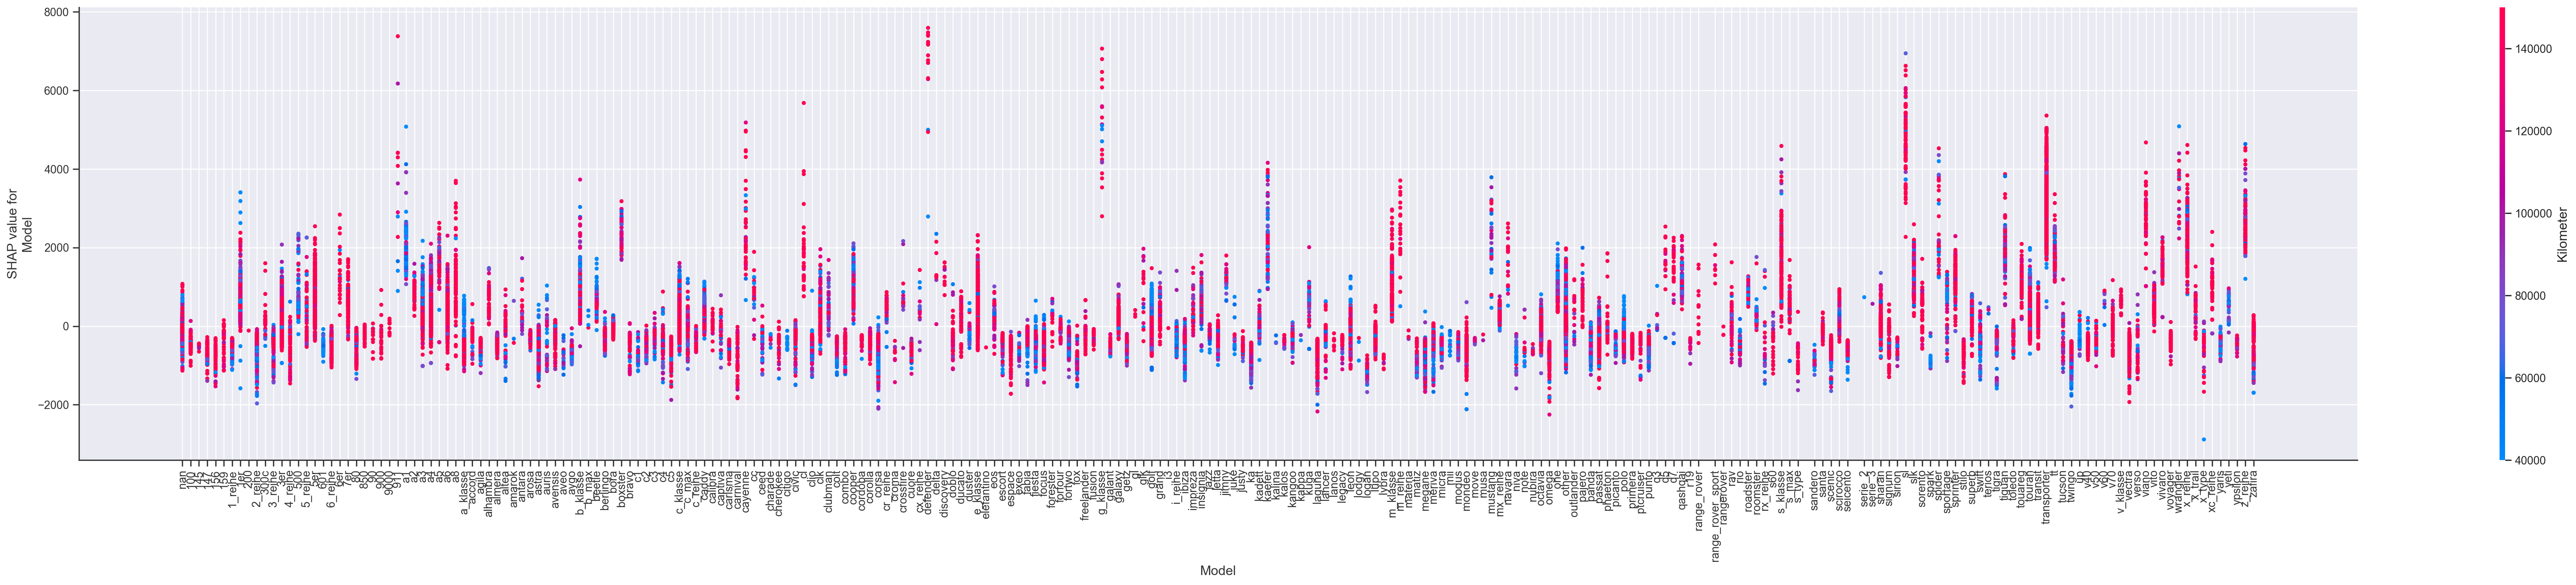

In [101]:
fig, ax = plt.subplots(figsize=(50,8))
shap.dependence_plot('Model', shap_values, test_data, display_features=test.reset_index(drop=True)[features], ax=ax)
plt.show()

### Вывод
Была проведена предобработка данных, в них было выявлено множество аномалий. Опробованы несолько моделей: линейная регрессия, метод k-ближайших соседей, метод случайного леса и градиентный бустинг.
Наилучшая модель - градиентный бустинг с настроенными гиперпараметрами, метрика качества RMSE: 1564.55. 